In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def give_centeroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([[sum_x/length, sum_y/length, sum_z/length]])

In [3]:
def give_next_neighbours_barycenter_indices(batch_x, input_barycenter, remaining_indices, no_of_barycenetrs_required):
    

  num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)
    
  wasserDistance = []
  distance_cum_index = np.array([])

  for j in remaining_indices:
    
    wassDistance = dist = np.linalg.norm(batch_x[j]-input_barycenter)

    
    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)
   
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  
  distance_cum_index = np.array(distance_cum_index)
  
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
  
    
  A = np.array([])
  for i in range(num_neighbours):
    if(i >= distance_cum_index[:,1].shape[0]):
        break
    A = np.concatenate((A, batch_x[int(distance_cum_index[:,1][i])]), axis = 0 )
  
  A = A.reshape(int(A.shape[0]/3) , 3)
  
  #print("The shape of A is ")
  #print(A.shape)
  next_barycenter = give_centeroid(A) 
  
  next_barycenter = np.array(next_barycenter)
  #print(next_barycenter.shape)
  next_barycenter = next_barycenter.reshape(next_barycenter.shape[0]* next_barycenter.shape[1])
  #print(next_barycenter.shape)  
  return A, next_barycenter, remaining_indices


In [4]:
def get_convergent_barycenters(point_cloud, no_of_barycenetrs_required, initial_pt):   
    
    no_neighbours = int(point_cloud.shape[0] / no_of_barycenetrs_required)
    
    #num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)

    
    bary = initial_pt
    rem_indices = np.array(range(0,point_cloud.shape[0]))
    #print("Size of batch : ", point_cloud.shape[0])
    sampled_barycenters = np.array([])
    sampled_barycenters = torch.tensor(sampled_barycenters)
    covered_indices = np.array([])

    for i in range(int(point_cloud.shape[0])):

        if(len(rem_indices) < 2):
            #print("END")
            break

        #print("Iteration number : ", i+1)
        #print("Input barycenter : ")


        old_bary = bary



        neighbours, bary, rem_indices = give_next_neighbours_barycenter_indices(point_cloud, bary, rem_indices, no_neighbours)


        wassDistance = np.linalg.norm(old_bary - bary)  

        covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)


        #print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
        if(wassDistance == 0.0):

            unique_covered_indices = np.unique(covered_indices, axis=0)
            sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

            s1 = set(rem_indices)
            s2 = set(unique_covered_indices)
            rem_set = s1 - s2
            rem_inds = list(rem_set)
            #rem_indices = rem_set
            rem_indices = rem_indices[no_neighbours:]

            #print("Sampled barycenters are")
            #print(sampled_barycenters)
    sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)
    
    return sampled_barycenters

In [5]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [6]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


# Torus in 3D

In [7]:
x, y, z = sp.symbols('x y z')


In [8]:
## Torus
R = 1.5
r = 0.7
expr_torus = (x**2 + y**2 + z**2 + R**2 - r**2)**2 - 4*R**2*(x**2 + y**2)


In [9]:
expr_torus

-9.0*x**2 - 9.0*y**2 + 3.0976*(0.568181818181818*x**2 + 0.568181818181818*y**2 + 0.568181818181818*z**2 + 1)**2

In [10]:
poly_torus = sp.Poly(expr_torus, x, y, z)

In [11]:
sp.expand(expr_torus)

1.0*x**4 + 2.0*x**2*y**2 + 2.0*x**2*z**2 - 5.48*x**2 + 1.0*y**4 + 2.0*y**2*z**2 - 5.48*y**2 + 1.0*z**4 + 3.52*z**2 + 3.0976

In [12]:
#Convert sympy polynomial to minterpy polynomial

newt_poly_torus = sympy_to_mp(poly_torus, mp.NewtonPolynomial)

# Trials on Torus : 

In [13]:
#Sample points on the zero isocontour
def points_on_torus(num_points):
    
    point_data_torus = sample_points_on_poly(num_points,        # Number of points to be sampled
                                       newt_poly_torus,  # Polynomial in Newton basis
                                       bounds=3.0, # Boundary of the Cubic domain to be sampled
                                       tol=1e-15)  # Tolerance in solution
    
    return point_data_torus

# 1. 1000 barycenters from 10000 points

In [14]:
#Sample points on the zero isocontour

point_data_torus = sample_points_on_poly(10000,        # Number of points to be sampled
                                   newt_poly_torus,  # Polynomial in Newton basis
                                   bounds=3.0, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [15]:
point_data_torus.shape

(10000, 3)

In [16]:
x_t = point_data_torus[:,0]
y_t = point_data_torus[:,1]
z_t = point_data_torus[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# demo of barycenter convergence on a torus


In [17]:
no_of_barycenetrs_required = 50

nachbarn = int(point_data_torus.shape[0] / no_of_barycenetrs_required)

int(nachbarn)

200

In [18]:
#demo of barycenter convergence on a torus

bary = point_data_torus[0]
rem_indices = np.array(range(0,point_data_torus.shape[0]))
print("Size of batch : ", point_data_torus.shape[0])
sampled_barycenters = np.array([])
sampled_barycenters = torch.tensor(sampled_barycenters)
covered_indices = np.array([])

for i in range(int(point_data_torus.shape[0])):
        
    if(len(rem_indices) < 2):
        print("END")
        break
    
    print("Iteration number : ", i+1)
    print("Input barycenter : ")
    print(bary)

    old_bary = bary
    
    
    
    neighbours, bary, rem_indices = give_next_neighbours_barycenter_indices(point_data_torus, bary, rem_indices, nachbarn)
    
    print("remaining indices")
    print(rem_indices)
    print("neighbours found : ")
    print(neighbours)

    
    wassDistance = np.linalg.norm(old_bary - bary)  
    
    covered_indices = np.concatenate((covered_indices, rem_indices[:nachbarn] ) ,axis = 0)
    #print("covered indices")
    #print(covered_indices)

    print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
    if(wassDistance == 0.0):

        unique_covered_indices = np.unique(covered_indices, axis=0)
        sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

        s1 = set(rem_indices)
        s2 = set(unique_covered_indices)
        rem_set = s1 - s2
        rem_inds = list(rem_set)
        rem_indices = rem_indices[nachbarn:]
        print("Sampled barycenters are")
        print(sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3))
sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)


Size of batch :  10000
Iteration number :  1
Input barycenter : 
[-0.51948001 -1.60498248  0.67457142]
remaining indices
[   0 5750  455 ... 3438 9919 1184]
neighbours found : 
[[-0.51948001 -1.60498248  0.67457142]
 [-0.53255678 -1.62206856  0.66861419]
 [-0.59217931 -1.61258575  0.66522825]
 [-0.49372953 -1.5336162   0.69112198]
 [-0.4872657  -1.53614093  0.69105152]
 [-0.47687178 -1.53933284  0.69106176]
 [-0.58245094 -1.53931645  0.68464201]
 [-0.48195932 -1.52303927  0.69317977]
 [-0.46628998 -1.68251958  0.65537367]
 [-0.42347359 -1.60771182  0.68086564]
 [-0.53936163 -1.6985497   0.64062743]
 [-0.4132368  -1.61572148  0.67960792]
 [-0.565849   -1.6947526   0.63858527]
 [-0.46543252 -1.51130314  0.69525703]
 [-0.62137035 -1.55660042  0.67750303]
 [-0.4132391  -1.64730368  0.67131158]
 [-0.63370776 -1.58399883  0.66898403]
 [-0.45771525 -1.70221495  0.64884473]
 [-0.62182973 -1.66068976  0.64444687]
 [-0.50155832 -1.71883033  0.63686885]
 [-0.56278025 -1.47662178  0.69538681]
 [-0

remaining indices
[4491 2668 9107 ... 6473 9919 1184]
neighbours found : 
[[-0.53936163 -1.6985497   0.64062743]
 [-0.50155832 -1.71883033  0.63686885]
 [-0.46628998 -1.68251958  0.65537367]
 [-0.565849   -1.6947526   0.63858527]
 [-0.45771525 -1.70221495  0.64884473]
 [-0.53255678 -1.62206856  0.66861419]
 [-0.53406789 -1.75197528  0.61649155]
 [-0.47027459 -1.74823645  0.6274249 ]
 [-0.51948001 -1.60498248  0.67457142]
 [-0.55521563 -1.7521199   0.61299771]
 [-0.51537279 -1.7646301   0.61279661]
 [-0.4437364  -1.73705328  0.6358049 ]
 [-0.56477452 -1.75785864  0.60830605]
 [-0.46599274 -1.76725005  0.61858091]
 [-0.59217931 -1.61258575  0.66522825]
 [-0.4132391  -1.64730368  0.67131158]
 [-0.62182973 -1.66068976  0.64444687]
 [-0.57108394 -1.76971644  0.60058565]
 [-0.42347359 -1.60771182  0.68086564]
 [-0.4132368  -1.61572148  0.67960792]
 [-0.63964744 -1.70776369  0.62069904]
 [-0.49910172 -1.80562015  0.59213549]
 [-0.43341404 -1.7872799   0.61239236]
 [-0.37736577 -1.69586411  0.

remaining indices
[7241 7008 3717 ... 9919 6473 3095]
neighbours found : 
[[-0.9818998  -1.67822559  0.54086667]
 [-0.95957634 -1.51786432  0.63445654]
 [-0.90997754 -1.43078229  0.67210472]
 [-0.98548914 -1.57575825  0.60120121]
 [-0.94762596 -1.81332349  0.43803926]
 [-0.86879078 -1.90110863  0.37635445]
 [-0.90250003 -1.3975156   0.68061436]
 [-0.72431314 -1.99393528  0.32224477]
 [-0.8632296  -1.91753063  0.35572472]
 [-1.01365291 -1.64376599  0.55143741]
 [-0.99958068 -1.73881087  0.48406599]
 [-1.01258415 -1.67902458  0.52700158]
 [-0.91193904 -1.38915428  0.68105794]
 [-0.78626906 -1.96920441  0.32424737]
 [-0.73358892 -1.99485755  0.31431069]
 [-0.94532239 -1.84956122  0.39611775]
 [-0.53866951 -1.20824692  0.67722255]
 [-0.65038414 -1.21873446  0.68988267]
 [-0.86112443 -1.93165895  0.33449438]
 [-0.6923455  -1.22302806  0.69357784]
 [-0.84311512 -1.29158516  0.69871397]
 [-0.84612966 -1.94905567  0.3156443 ]
 [-1.03080178 -1.55222518  0.59833082]
 [-1.0347475  -1.71411757  0.

remaining indices
[4925 4109 9577 ... 1798 4995 7189]
neighbours found : 
[[-1.11414966 -1.74623145  0.40436894]
 [-1.10874353 -1.75876343  0.3932809 ]
 [-1.09460279 -1.76913866  0.39134618]
 [-1.06604253 -1.74508945  0.43936233]
 [-1.08694736 -1.69893932  0.47204203]
 [-1.10424719 -1.79554267  0.34703141]
 [-1.03163738 -1.73835518  0.46703015]
 [-1.07927224 -1.81593907  0.33896857]
 [-1.01560651 -1.80312333  0.40706602]
 [-1.0347475  -1.71411757  0.48761761]
 [-1.01763073 -1.80799815  0.39963257]
 [-1.12631999 -1.66141784  0.48242563]
 [-1.06253091 -1.82980792  0.33260722]
 [-0.99958068 -1.73881087  0.48406599]
 [-1.20777501 -1.72773004  0.34685008]
 [-1.21621989 -1.69521729  0.38231747]
 [-1.21228167 -1.67443751  0.41020714]
 [-0.99264429 -1.82654976  0.39361156]
 [-1.22015807 -1.67034642  0.40837036]
 [-1.19515676 -1.76359091  0.3042721 ]
 [-1.2043431  -1.63702573  0.45458005]
 [-1.13076243 -1.62387564  0.51065012]
 [-1.01258415 -1.67902458  0.52700158]
 [-1.17440077 -1.7959426   0.

remaining indices
[7870 3569 3820 ... 7189 5502 1798]
neighbours found : 
[[-1.51419422 -1.59562844 -0.01942242]
 [-1.31030056 -1.26306656  0.62260005]
 [-0.58321854 -2.05796987  0.28576252]
 [-1.02677952 -1.25783495  0.68898225]
 [-1.55003801 -1.55994031  0.03552641]
 [-1.5923361  -1.48847146  0.16736548]
 [-1.56082056 -1.37771803  0.38910606]
 [-1.5372062  -1.35351963  0.43532155]
 [-1.57521959 -1.38847586  0.36087906]
 [-1.21704512 -1.24022814  0.65843077]
 [-1.48799962 -1.31405324  0.50459413]
 [-1.54456155 -1.56662372 -0.0025053 ]
 [-0.7593152  -2.06302896 -0.04834614]
 [-1.54288789 -1.33804937  0.44265105]
 [-1.44499148 -1.2814792   0.55128948]
 [-1.02240072 -1.90576795 -0.2254635 ]
 [-1.52953855 -1.32388073  0.46537018]
 [-1.42326711 -1.26673736  0.57070231]
 [-1.39111674 -1.25472055  0.59210809]
 [-0.84311512 -1.29158516  0.69871397]
 [-0.76169707 -2.06062095 -0.06587434]
 [-1.28990722 -1.73631877 -0.22450398]
 [-1.00850406 -1.22764957  0.69434798]
 [-1.08565568 -1.21554583  0.

remaining indices
[4786 1598 7119 ... 4349 1159 4063]
neighbours found : 
[[-1.63880703 -1.24631413  0.42148902]
 [-1.59986777 -1.22907208  0.47140457]
 [-1.59637634 -1.24271692  0.46519949]
 [-1.66352016 -1.1929396   0.43673657]
 [-1.61815357 -1.19004866  0.48092079]
 [-1.65251369 -1.25586818  0.39839033]
 [-1.62060886 -1.18388293  0.4826754 ]
 [-1.68033452 -1.22774118  0.39032298]
 [-1.68879853 -1.20136481  0.40277378]
 [-1.57553799 -1.28536699  0.45336967]
 [-1.67307813 -1.15753327  0.45204023]
 [-1.57838843 -1.29969214  0.43974848]
 [-1.70285381 -1.16910242  0.4124914 ]
 [-1.6282695  -1.14678812  0.49834793]
 [-1.55947397 -1.29481119  0.46079476]
 [-1.56015321 -1.30036632  0.45609298]
 [-1.6380048  -1.12339352  0.50357663]
 [-1.71909073 -1.20832856  0.35843515]
 [-1.69331864 -1.12213832  0.45566507]
 [-1.70366425 -1.12547486  0.44316457]
 [-1.69979517 -1.25674777  0.3362805 ]
 [-1.65373971 -1.1064473   0.50015092]
 [-1.54288789 -1.33804937  0.44265105]
 [-1.52953855 -1.32388073  0.

remaining indices
[9213 8043 6913 ... 1127 4349 1159]
neighbours found : 
[[-1.62060886 -1.18388293  0.4826754 ]
 [-1.61815357 -1.19004866  0.48092079]
 [-1.66352016 -1.1929396   0.43673657]
 [-1.67307813 -1.15753327  0.45204023]
 [-1.6282695  -1.14678812  0.49834793]
 [-1.59986777 -1.22907208  0.47140457]
 [-1.6380048  -1.12339352  0.50357663]
 [-1.59637634 -1.24271692  0.46519949]
 [-1.63880703 -1.24631413  0.42148902]
 [-1.69331864 -1.12213832  0.45566507]
 [-1.68879853 -1.20136481  0.40277378]
 [-1.70285381 -1.16910242  0.4124914 ]
 [-1.65373971 -1.1064473   0.50015092]
 [-1.70366425 -1.12547486  0.44316457]
 [-1.68033452 -1.22774118  0.39032298]
 [-1.65251369 -1.25586818  0.39839033]
 [-1.71390193 -1.10499377  0.44634943]
 [-1.57553799 -1.28536699  0.45336967]
 [-1.65268878 -1.07282963  0.51841633]
 [-1.61297117 -1.08275465  0.54224351]
 [-1.5413153  -1.16772587  0.54944986]
 [-1.62551866 -1.07448972  0.53740557]
 [-1.74133308 -1.1462154   0.3848434 ]
 [-1.57838843 -1.29969214  0.

remaining indices
[6314 3643 8241 ... 1127 4349 1159]
neighbours found : 
[[-1.67633877 -1.42430612 -0.01986495]
 [-1.4790099  -0.70101546  0.68651602]
 [-1.85539615 -1.17949221 -0.04476805]
 [-1.95664551 -1.00280564  0.04338377]
 [-1.56944375 -0.66406386  0.66956845]
 [-1.94982593 -0.71891849  0.39465731]
 [-1.13991938 -1.09973772  0.69494999]
 [-1.2438829  -0.8571812   0.69991928]
 [-1.74443069 -0.64035076  0.60138009]
 [-1.94192443 -0.70237347  0.41319172]
 [-1.63672578 -1.46988948 -0.01327212]
 [-1.14308863 -1.05454846  0.69781819]
 [-1.37925815 -0.73167138  0.69730969]
 [-1.12956636 -1.10644073  0.69527675]
 [-1.28646382 -0.79772734  0.69986547]
 [-1.99804708 -0.77119231  0.27965315]
 [-1.75510387 -0.63094016  0.59726548]
 [-1.67894565 -0.63068091  0.6355013 ]
 [-1.75895035 -1.31440719 -0.07649366]
 [-1.26264424 -0.8142912   0.69999573]
 [-1.11365712 -1.21103694  0.68476483]
 [-1.98423324 -0.9428086   0.06652489]
 [-1.76702128 -0.62750241  0.59099517]
 [-1.96475447 -0.98889197  0.

remaining indices
[8612 1083 9301 ... 3565 8313 8271]
neighbours found : 
[[-1.74513742 -0.52602271  0.62118448]
 [-1.75407543 -0.56460774  0.61037131]
 [-1.76796873 -0.56970162  0.60183061]
 [-1.70154373 -0.56020555  0.63646787]
 [-1.71657306 -0.58341215  0.62612051]
 [-1.70216558 -0.50863437  0.64306174]
 [-1.68293522 -0.56128929  0.64411709]
 [-1.74445137 -0.46163252  0.63030199]
 [-1.76702128 -0.62750241  0.59099517]
 [-1.75510387 -0.63094016  0.59726548]
 [-1.67295173 -0.59540362  0.64340056]
 [-1.74443069 -0.64035076  0.60138009]
 [-1.8382639  -0.48552316  0.57354791]
 [-1.63912056 -0.54102645  0.66247882]
 [-1.67894565 -0.63068091  0.6355013 ]
 [-1.64189184 -0.50495383  0.66525894]
 [-1.63224878 -0.54466865  0.66428892]
 [-1.8441141  -0.58878556  0.5477728 ]
 [-1.75394684 -0.40644199  0.6322545 ]
 [-1.86155048 -0.48717156  0.55679344]
 [-1.63321965 -0.60748174  0.65663922]
 [-1.84117837 -0.61808602  0.54267714]
 [-1.612081   -0.54838572  0.66997885]
 [-1.61064823 -0.4730997   0.

remaining indices
[3482 4561 4788 ... 5176 4076 8271]
neighbours found : 
[[-1.64189184 -0.50495383  0.66525894]
 [-1.63912056 -0.54102645  0.66247882]
 [-1.63224878 -0.54466865  0.66428892]
 [-1.61064823 -0.4730997   0.67680774]
 [-1.612081   -0.54838572  0.66997885]
 [-1.5902286  -0.54355854  0.67631204]
 [-1.57567115 -0.53796883  0.68028114]
 [-1.56508075 -0.5179477   0.6840542 ]
 [-1.68293522 -0.56128929  0.64411709]
 [-1.70216558 -0.50863437  0.64306174]
 [-1.57315644 -0.57907535  0.67742207]
 [-1.53703388 -0.5057276   0.68996624]
 [-1.54049707 -0.53785444  0.68750071]
 [-1.70154373 -0.56020555  0.63646787]
 [-1.63321965 -0.60748174  0.65663922]
 [-1.57046466 -0.42511817  0.6883854 ]
 [-1.67295173 -0.59540362  0.64340056]
 [-1.71657306 -0.58341215  0.62612051]
 [-1.61770812 -0.38151613  0.68097556]
 [-1.74513742 -0.52602271  0.62118448]
 [-1.54725736 -0.40489308  0.69291279]
 [-1.74445137 -0.46163252  0.63030199]
 [-1.67894565 -0.63068091  0.6355013 ]
 [-1.49747219 -0.45524322  0.

remaining indices
[ 741 7115 7393 ... 5176 5460 4160]
neighbours found : 
[[-1.3199178  -0.0098526   0.67644929]
 [-1.21369843 -0.05563554  0.63934307]
 [-1.33319883  0.01139023  0.67984822]
 [-1.16110486 -0.0981342   0.61476725]
 [-1.10099243 -0.22647561  0.59047209]
 [-1.11523717 -0.14448014  0.59079824]
 [-1.23935033 -0.00823622  0.64967378]
 [-1.31328934  0.03054213  0.67473817]
 [-1.07501085 -0.2732662   0.58075355]
 [-1.07758623 -0.23602701  0.57662467]
 [-1.41010535  0.05394862  0.69433663]
 [-1.15381341 -0.06642332  0.60948657]
 [-1.06770862 -0.24584838  0.57140085]
 [-1.29687911  0.0444139   0.67011207]
 [-1.05093056 -0.32074591  0.57360977]
 [-1.08866977 -0.12602497  0.57160773]
 [-1.27884634  0.0473307   0.66443778]
 [-1.16699226 -0.0135352   0.61575816]
 [-1.21069716  0.02129587  0.63750466]
 [-1.13955472 -0.02174935  0.60019061]
 [-1.11742201 -0.0425301   0.58673034]
 [-1.62559175  0.06567219  0.68839806]
 [-1.19240077  0.0307141   0.62898797]
 [-1.40211955  0.10110859  0.

remaining indices
[2290 6871 4724 ... 2168 1389 4286]
neighbours found : 
[[-1.12818072  0.01282293  0.59313119]
 [-1.10196723 -0.01676827  0.57590924]
 [-1.13955472 -0.02174935  0.60019061]
 [-1.14884883  0.01807791  0.60563415]
 [-1.11742201 -0.0425301   0.58673034]
 [-1.08930692  0.02914828  0.56714312]
 [-1.16699226 -0.0135352   0.61575816]
 [-1.08185566  0.06419528  0.56279934]
 [-1.14864772  0.07019529  0.60667354]
 [-1.15381341 -0.06642332  0.60948657]
 [-1.19240077  0.0307141   0.62898797]
 [-1.21069716  0.02129587  0.63750466]
 [-1.07453582 -0.09727231  0.55919562]
 [-1.16110486 -0.0981342   0.61476725]
 [-1.21369843 -0.05563554  0.63934307]
 [-1.0156637  -0.02050813  0.50558763]
 [-1.08866977 -0.12602497  0.57160773]
 [-1.23935033 -0.00823622  0.64967378]
 [-1.11523717 -0.14448014  0.59079824]
 [-1.02079102  0.0870085   0.51370475]
 [-1.21822334  0.10759178  0.64284661]
 [-1.00329262 -0.05888246  0.49496851]
 [-1.19230333  0.14834525  0.63316316]
 [-0.9907896   0.06194898  0.

remaining indices
[8055 9328 3204 ... 8472 8385 8666]
neighbours found : 
[[-0.78102495  0.37916082  0.30136804]
 [-0.77727558  0.40826084  0.32106191]
 [-0.76519383  0.44010268  0.33011746]
 [-0.75635884  0.41347151  0.28801234]
 [-0.77488736  0.30072319  0.20663893]
 [-0.80318899  0.50734614  0.43302117]
 [-0.75638528  0.49852427  0.37018759]
 [-0.76020786  0.51513287  0.3893931 ]
 [-0.79708765  0.5314894   0.44302728]
 [-0.77782973  0.52924517  0.42107507]
 [-0.86413314  0.53311206  0.50508798]
 [-0.73884904  0.36808083  0.18706548]
 [-0.7795411   0.5324922   0.42534773]
 [-0.7920754   0.55810985  0.45605828]
 [-0.79236976  0.19341734  0.14711985]
 [-0.72946588  0.53788017  0.37088664]
 [-0.94306099  0.53585053  0.56346914]
 [-0.76002993  0.28233575  0.12235741]
 [-0.75651598  0.29116342  0.12142829]
 [-0.73730696  0.5583661   0.39903828]
 [-0.76664242  0.25844004  0.11208228]
 [-0.78677834  0.18628322  0.10894932]
 [-0.67967646  0.48598005  0.2202284 ]
 [-0.67843731  0.48634222  0.

Sampled barycenters are
tensor([[-0.5098, -1.6947,  0.6377],
        [-1.0979, -1.7650,  0.3746],
        [-1.6395, -1.1724,  0.4629],
        [-1.5782, -0.5168,  0.6726],
        [-1.1053, -0.0294,  0.5680],
        [-0.6712,  0.5970,  0.3524]], dtype=torch.float64)
Iteration number :  60
Input barycenter : 
[-0.67120635  0.5969633   0.35235501]
remaining indices
[  85 4595 8295 ... 4860 4985 4807]
neighbours found : 
[[-0.8918667   1.01009591  0.68318346]
 [-0.15939934  0.82149612  0.22402982]
 [-0.62032006  0.55875126 -0.21816446]
 [-0.91994804  0.99378295  0.68465165]
 [-0.18823248  0.78559528  0.10441502]
 [-0.38341125  0.7164477  -0.13216141]
 [-0.64382653  1.08690821  0.65875998]
 [-0.15301215  0.84393106  0.27827689]
 [-0.45608615  1.06730403  0.61225359]
 [-1.1516344   0.62738437  0.67412525]
 [-0.78976593  0.13131407  0.02917546]
 [-0.17550063  0.89610073  0.38154627]
 [-0.19859572  0.92430836  0.42710864]
 [-0.79433944  0.11225175  0.05585076]
 [-0.68129372  0.4823503  -0.21

remaining indices
[2921 7830 2459 ... 5801 9852 3406]
neighbours found : 
[[-0.07208796  0.97724163  0.46850052]
 [-0.04030775  0.89540875  0.35435162]
 [-0.08975275  0.90177521  0.37072634]
 [-0.10114372  0.97050946  0.46387324]
 [ 0.02284176  0.99665607  0.48673225]
 [-0.07546411  0.88595197  0.34186934]
 [ 0.00852905  1.0086684   0.49862681]
 [-0.080029    1.00934526  0.50235086]
 [ 0.08448904  0.96746541  0.45860131]
 [-0.04757387  1.03003047  0.51976874]
 [ 0.10678013  0.94309139  0.43188897]
 [-0.04571373  0.86430307  0.29567532]
 [-0.17550063  0.89610073  0.38154627]
 [-0.06928356  0.85899838  0.2875506 ]
 [-0.1898691   0.93612351  0.43951804]
 [-0.11611305  1.03282398  0.5270517 ]
 [-0.19859572  0.92430836  0.42710864]
 [-0.00654696  1.05876903  0.54344558]
 [-0.20119597  0.96278601  0.47256123]
 [ 0.14959695  0.92619127  0.41758226]
 [-0.13861028  1.04972893  0.54348732]
 [ 0.16103322  0.91339667  0.40277111]
 [ 0.09744962  1.04078637  0.53224334]
 [ 0.1428322   1.00655344  0.

remaining indices
[6026 9066 2260 ... 2800 3406 9852]
neighbours found : 
[[ 0.00852905  1.0086684   0.49862681]
 [ 0.02284176  0.99665607  0.48673225]
 [-0.00654696  1.05876903  0.54344558]
 [ 0.09744962  1.04078637  0.53224334]
 [-0.04757387  1.03003047  0.51976874]
 [ 0.08448904  0.96746541  0.45860131]
 [ 0.01992435  1.08937239  0.56704018]
 [-0.080029    1.00934526  0.50235086]
 [-0.07208796  0.97724163  0.46850052]
 [ 0.1428322   1.00655344  0.5063203 ]
 [ 0.02213312  1.10116067  0.57541685]
 [ 0.13191488  1.05689509  0.54850544]
 [ 0.10678013  0.94309139  0.43188897]
 [ 0.14021339  1.05357534  0.5467289 ]
 [ 0.16886893  0.9910744   0.4953075 ]
 [-0.10114372  0.97050946  0.46387324]
 [-0.11611305  1.03282398  0.5270517 ]
 [ 0.0867834   1.12232058  0.59150459]
 [ 0.14959695  0.92619127  0.41758226]
 [-0.13861028  1.04972893  0.54348732]
 [ 0.18825455  0.94187022  0.44602602]
 [-0.13164557  1.08057544  0.56632259]
 [-0.03112036  1.15464593  0.60911412]
 [ 0.07104209  1.15949191  0.

remaining indices
[7676 2187 8826 ...   37  973 3949]
neighbours found : 
[[ 0.09744962  1.04078637  0.53224334]
 [ 0.13191488  1.05689509  0.54850544]
 [ 0.14021339  1.05357534  0.5467289 ]
 [ 0.1428322   1.00655344  0.5063203 ]
 [ 0.16886893  0.9910744   0.4953075 ]
 [ 0.0867834   1.12232058  0.59150459]
 [ 0.01992435  1.08937239  0.56704018]
 [ 0.08448904  0.96746541  0.45860131]
 [ 0.02213312  1.10116067  0.57541685]
 [ 0.02284176  0.99665607  0.48673225]
 [ 0.00852905  1.0086684   0.49862681]
 [-0.00654696  1.05876903  0.54344558]
 [ 0.16745194  1.1507553   0.61347097]
 [ 0.07104209  1.15949191  0.61280525]
 [ 0.10678013  0.94309139  0.43188897]
 [ 0.18825455  0.94187022  0.44602602]
 [ 0.22955271  1.12712296  0.60636846]
 [ 0.22107262  0.95301967  0.46674948]
 [-0.04757387  1.03003047  0.51976874]
 [ 0.14960589  1.17921367  0.62695384]
 [ 0.15842836  1.1785321   0.62718558]
 [ 0.23717754  1.13185065  0.60988708]
 [ 0.19051005  1.16830238  0.62448009]
 [ 0.22843374  0.94456928  0.

remaining indices
[8826 2187 3483 ... 5425  973 3949]
neighbours found : 
[[ 0.14021339  1.05357534  0.5467289 ]
 [ 0.13191488  1.05689509  0.54850544]
 [ 0.22955271  1.12712296  0.60636846]
 [ 0.23717754  1.13185065  0.60988708]
 [ 0.1428322   1.00655344  0.5063203 ]
 [ 0.16886893  0.9910744   0.4953075 ]
 [ 0.30680742  1.09064432  0.59606525]
 [ 0.09744962  1.04078637  0.53224334]
 [ 0.31397053  1.07502895  0.5878385 ]
 [ 0.16745194  1.1507553   0.61347097]
 [ 0.2678455   0.96743256  0.49377275]
 [ 0.19051005  1.16830238  0.62448009]
 [ 0.27863559  1.14585072  0.6221851 ]
 [ 0.22107262  0.95301967  0.46674948]
 [ 0.0867834   1.12232058  0.59150459]
 [ 0.24131075  0.95149953  0.47040887]
 [ 0.34017448  1.0061713   0.54613304]
 [ 0.15842836  1.1785321   0.62718558]
 [ 0.14960589  1.17921367  0.62695384]
 [ 0.35399328  1.04186007  0.57470409]
 [ 0.35406596  1.0592154   0.58581359]
 [ 0.22843374  0.94456928  0.45935128]
 [ 0.18825455  0.94187022  0.44602602]
 [ 0.35063215  1.1307498   0.

remaining indices
[5734 4748 2078 ... 2487 9383 9603]
neighbours found : 
[[ 0.44254111  1.53474936  0.6932077 ]
 [ 0.64127271  1.3929888   0.69919752]
 [ 0.61771389  1.42914812  0.69768104]
 [ 0.72364335  1.24030668  0.69706573]
 [ 0.62102441  1.43951867  0.69671227]
 [ 0.5665999   1.49575771  0.69289561]
 [ 0.6823937   1.37265721  0.6992254 ]
 [ 0.4598507   1.55746218  0.68894206]
 [ 0.74821718  1.20884615  0.69560333]
 [ 0.3333108   1.58583839  0.68955259]
 [ 0.72669279  1.30005179  0.69991925]
 [ 0.74843109  1.23217146  0.697565  ]
 [ 0.21025926  1.57593338  0.69420342]
 [ 0.73907391  0.97994522  0.64474175]
 [ 0.58751161  1.50358249  0.69060694]
 [ 0.47128091  1.57954344  0.68409925]
 [ 0.74094352  0.94641639  0.63338024]
 [ 0.70981981  0.88188432  0.59550109]
 [ 0.68884611  1.41443934  0.69615583]
 [ 0.41043638  1.60138732  0.68304143]
 [ 0.77849067  1.13990772  0.68970287]
 [ 0.52796286  1.56626651  0.68310673]
 [ 0.54675343  1.55921395  0.68323161]
 [ 0.77894963  1.04163877  0.

remaining indices
[ 965 1333 4090 ... 2464 2038 5136]
neighbours found : 
[[0.82020313 1.38127144 0.69186046]
 [0.82619241 1.34643193 0.69544724]
 [0.84031123 1.42628082 0.68252917]
 [0.86865033 1.30300021 0.69688142]
 [0.91517624 1.3647071  0.68520462]
 [0.92173116 1.34564289 0.68762226]
 [0.76355733 1.32262216 0.69947122]
 [0.74644633 1.33778065 0.69927095]
 [0.77921799 1.475723   0.67933935]
 [0.81824515 1.24449941 0.6999197 ]
 [0.72669279 1.30005179 0.69991925]
 [0.87874167 1.23883589 0.69974619]
 [0.87316693 1.50272811 0.65830111]
 [0.96822787 1.31001193 0.68801346]
 [0.88019796 1.23478761 0.69980801]
 [0.95099532 1.46890817 0.65388035]
 [0.68884611 1.41443934 0.69615583]
 [0.6823937  1.37265721 0.6992254 ]
 [1.00461623 1.36033293 0.67341484]
 [0.83870947 1.53333245 0.65470025]
 [0.74843109 1.23217146 0.697565  ]
 [0.79713928 1.20627858 0.69790394]
 [0.97257615 1.26364912 0.69357981]
 [0.85144952 1.5401304  0.64999488]
 [0.79529373 1.20248303 0.6975668 ]
 [0.72364335 1.24030668 0.

remaining indices
[4604 5874 3532 ... 4945 7030 2038]
neighbours found : 
[[0.86865033 1.30300021 0.69688142]
 [0.87874167 1.23883589 0.69974619]
 [0.88019796 1.23478761 0.69980801]
 [0.97257615 1.26364912 0.69357981]
 [0.96822787 1.31001193 0.68801346]
 [0.92173116 1.34564289 0.68762226]
 [0.91517624 1.3647071  0.68520462]
 [0.96233925 1.19230771 0.69925814]
 [0.81824515 1.24449941 0.6999197 ]
 [0.82619241 1.34643193 0.69544724]
 [1.00461623 1.36033293 0.67341484]
 [0.83102925 1.18959732 0.69829136]
 [0.83458075 1.17324178 0.69740651]
 [0.82020313 1.38127144 0.69186046]
 [0.79713928 1.20627858 0.69790394]
 [0.79529373 1.20248303 0.6975668 ]
 [1.06221479 1.30471476 0.67580929]
 [0.9393198  1.13275554 0.69942158]
 [0.885502   1.13247983 0.69721103]
 [1.04226475 1.19661388 0.69458706]
 [1.05948909 1.22312894 0.68994889]
 [0.76355733 1.32262216 0.69947122]
 [1.0116274  1.40769029 0.65991149]
 [0.84031123 1.42628082 0.68252917]
 [0.86489249 1.11670876 0.69450621]
 [1.05481065 1.37667877 0.

remaining indices
[4235 4666 5840 ...   32 4528 1053]
neighbours found : 
[[1.47221743 1.33433873 0.50289248]
 [1.47674628 1.22230785 0.5622516 ]
 [1.52931803 1.28614288 0.49168425]
 [1.51840036 1.21766316 0.53923995]
 [1.54131221 1.25515601 0.50211757]
 [1.54194328 1.25446901 0.50206341]
 [1.50503923 1.19948796 0.55655413]
 [1.53576428 1.31951635 0.46326664]
 [1.54236447 1.32075336 0.456595  ]
 [1.52307106 1.35388911 0.44803597]
 [1.52399377 1.18096245 0.55390066]
 [1.52096537 1.15558255 0.56724752]
 [1.4775375  1.41398232 0.43915629]
 [1.4138597  1.42669965 0.4809644 ]
 [1.46665684 1.4241427  0.44012532]
 [1.59795763 1.18910948 0.49808397]
 [1.56449452 1.35561206 0.40618021]
 [1.59987291 1.17381969 0.50542421]
 [1.41400895 1.44278264 0.4684383 ]
 [1.62085355 1.22610969 0.45451792]
 [1.6153403  1.27185044 0.42534726]
 [1.47552522 1.11771519 0.60559848]
 [1.54086308 1.11683428 0.57232443]
 [1.62527445 1.19552725 0.47123928]
 [1.56721974 1.11796656 0.5561351 ]
 [1.58255074 1.36558649 0.

remaining indices
[6784 5408 5070 ... 1655 6167 5051]
neighbours found : 
[[1.62527445 1.19552725 0.47123928]
 [1.59795763 1.18910948 0.49808397]
 [1.59987291 1.17381969 0.50542421]
 [1.62085355 1.22610969 0.45451792]
 [1.64110016 1.14547955 0.48853392]
 [1.54194328 1.25446901 0.50206341]
 [1.54131221 1.25515601 0.50211757]
 [1.6153403  1.27185044 0.42534726]
 [1.68179763 1.16239603 0.44002151]
 [1.67517487 1.20861092 0.41234545]
 [1.51840036 1.21766316 0.53923995]
 [1.52399377 1.18096245 0.55390066]
 [1.67620901 1.11096852 0.47846433]
 [1.52931803 1.28614288 0.49168425]
 [1.56721974 1.11796656 0.5561351 ]
 [1.58750538 1.1000297  0.55127948]
 [1.50503923 1.19948796 0.55655413]
 [1.52096537 1.15558255 0.56724752]
 [1.60075794 1.08909288 0.54754169]
 [1.54236447 1.32075336 0.456595  ]
 [1.54086308 1.11683428 0.57232443]
 [1.53576428 1.31951635 0.46326664]
 [1.62492197 1.07265998 0.5386593 ]
 [1.71725109 1.17284553 0.39258713]
 [1.69434835 1.2335608  0.36741097]
 [1.47674628 1.22230785 0.

remaining indices
[ 545 7673 9594 ... 1655 1529 1653]
neighbours found : 
[[1.64110016 1.14547955 0.48853392]
 [1.60075794 1.08909288 0.54754169]
 [1.62492197 1.07265998 0.5386593 ]
 [1.58750538 1.1000297  0.55127948]
 [1.59987291 1.17381969 0.50542421]
 [1.67620901 1.11096852 0.47846433]
 [1.56721974 1.11796656 0.5561351 ]
 [1.63420788 1.04573422 0.54430224]
 [1.59795763 1.18910948 0.49808397]
 [1.65759551 1.0366177  0.53191585]
 [1.62527445 1.19552725 0.47123928]
 [1.54086308 1.11683428 0.57232443]
 [1.60620074 1.02729368 0.5697871 ]
 [1.57359729 1.04730342 0.58112247]
 [1.68179763 1.16239603 0.44002151]
 [1.58406382 1.03266975 0.58065795]
 [1.5400048  1.08042754 0.58709581]
 [1.72116315 1.08486571 0.45196394]
 [1.52096537 1.15558255 0.56724752]
 [1.69618032 1.01707706 0.51162502]
 [1.52399377 1.18096245 0.55390066]
 [1.62085355 1.22610969 0.45451792]
 [1.73153444 1.05417901 0.46050976]
 [1.67517487 1.20861092 0.41234545]
 [1.51840036 1.21766316 0.53923995]
 [1.50503923 1.19948796 0.

remaining indices
[7245  614 6344 ... 2289 2691 1208]
neighbours found : 
[[ 1.95144731  0.99072609  0.12617353]
 [ 1.97402745  0.7270072   0.35441821]
 [ 2.00411452  0.75790839  0.27751691]
 [ 1.99616972  0.88934657  0.14259799]
 [ 1.98355706  0.66967951  0.3710706 ]
 [ 1.96229613  0.98837649  0.06303652]
 [ 1.92843812  1.05445727  0.05421243]
 [ 1.98439114  0.66115862  0.37412228]
 [ 1.83348309  0.62081381  0.54784579]
 [ 1.8363746   0.619142    0.54608536]
 [ 2.02893903  0.81618809  0.1345278 ]
 [ 2.00852214  0.88596676  0.08145625]
 [ 1.98812723  0.9408911   0.02568609]
 [ 2.03237951  0.82925015  0.08314164]
 [ 1.92574339  0.58424233  0.47689377]
 [ 2.04533781  0.78090665  0.12168193]
 [ 1.91978612  1.07443227 -0.00229407]
 [ 1.81637241  1.23722087  0.05658927]
 [ 2.05385906  0.72333165  0.17601555]
 [ 1.90260435  1.10416206 -0.01713491]
 [ 1.68824324  0.59339848  0.63733312]
 [ 1.89559694  0.55152821  0.51491071]
 [ 1.88730548  1.1295606  -0.02627861]
 [ 1.90872666  0.54051308  0.

remaining indices
[1905 8240  203 ... 5513 2914 4037]
neighbours found : 
[[2.06862037 0.5026947  0.30753894]
 [2.06924558 0.45219268 0.328602  ]
 [2.0805075  0.47041784 0.29879216]
 [2.08269746 0.46455884 0.29697847]
 [2.07010288 0.51862287 0.29655201]
 [2.03723408 0.5331034  0.35067   ]
 [2.02432297 0.52081599 0.37630893]
 [2.04614314 0.5569925  0.3238151 ]
 [2.09911639 0.45486633 0.26516122]
 [2.03533151 0.55719373 0.34297003]
 [2.07780638 0.39150523 0.33548606]
 [2.07330048 0.38550981 0.345424  ]
 [2.04401855 0.5909963  0.30974063]
 [2.03347272 0.38829619 0.40602488]
 [2.07588028 0.60456629 0.22713888]
 [1.97199859 0.52212374 0.44548305]
 [2.09699655 0.5690533  0.19311071]
 [2.11398034 0.52371147 0.17455897]
 [1.96054331 0.52911717 0.45647553]
 [2.07760607 0.61633717 0.21208204]
 [2.08680241 0.30583215 0.34497025]
 [1.97731099 0.40927161 0.46947561]
 [2.12094067 0.3124097  0.27475136]
 [1.9507421  0.47819724 0.48107068]
 [2.14124143 0.40965107 0.16582347]
 [1.98507921 0.38152741 0.

remaining indices
[4479 7838 3341 ... 1325 2914 4037]
neighbours found : 
[[ 2.07412156  0.47567549 -0.30928354]
 [ 2.06724324  0.49754619 -0.31269666]
 [ 2.08460874  0.41832623 -0.31291152]
 [ 1.44520907  0.48913926  0.69952654]
 [ 1.54398574  0.11583578  0.69832994]
 [ 1.84615203 -0.15962829  0.60445225]
 [ 1.62296569  0.01049283  0.68910891]
 [ 2.03045384 -0.23108699  0.44106778]
 [ 1.97052837  0.96829219 -0.07853896]
 [ 2.04507488  0.58777999 -0.309489  ]
 [ 1.64363285 -0.01626883  0.68508866]
 [ 1.92843812  1.05445727  0.05421243]
 [ 1.50739707  0.15714509  0.69982691]
 [ 2.10224248 -0.23650427  0.33339866]
 [ 1.45732124  0.26158433  0.69973145]
 [ 2.03680569  0.61234055 -0.31152061]
 [ 1.43363248  0.56220812  0.69886029]
 [ 1.64122297 -0.02995628  0.68554999]
 [ 1.52508989  0.0995293   0.69942632]
 [ 1.96110666 -0.23547388  0.51399576]
 [ 2.10370578  0.27786008 -0.32116232]
 [ 1.99191409 -0.24891499  0.48222273]
 [ 2.15707901 -0.23212436  0.20426976]
 [ 2.19022122 -0.1787864   0.

remaining indices
[1019  827  328 ... 7232  735 9450]
neighbours found : 
[[ 1.40509974 -0.01034013  0.69354247]
 [ 1.41947075 -0.00121139  0.69535252]
 [ 1.43746809 -0.09409832  0.69747048]
 [ 1.45566296  0.01466799  0.69859915]
 [ 1.43690488  0.02787335  0.69717505]
 [ 1.43543937 -0.13918081  0.69760721]
 [ 1.4078436  -0.14720395  0.69488335]
 [ 1.32211045 -0.05096011  0.67727663]
 [ 1.43744381  0.05499015  0.69729274]
 [ 1.32816069 -0.09921237  0.67950666]
 [ 1.52004257  0.00148343  0.69971299]
 [ 1.33400599  0.02745528  0.68010271]
 [ 1.31993092 -0.1078166   0.67759797]
 [ 1.45700653 -0.17182179  0.69922656]
 [ 1.38048549  0.07284109  0.6900519 ]
 [ 1.37575035 -0.17062602  0.6907027 ]
 [ 1.55119051 -0.09714823  0.69789623]
 [ 1.44419251 -0.18389787  0.69860655]
 [ 1.54801593  0.00877412  0.69834954]
 [ 1.28695811 -0.07938866  0.66756985]
 [ 1.40749438 -0.19345294  0.69549676]
 [ 1.51983717 -0.16020309  0.69942943]
 [ 1.31022347 -0.14373015  0.67594849]
 [ 1.54721137  0.03434711  0.

remaining indices
[1885  769 9902 ... 2056 7439 7923]
neighbours found : 
[[ 0.84913682 -0.40885873  0.42323775]
 [ 0.89423536 -0.39582846  0.466302  ]
 [ 0.89703233 -0.35735852  0.4521177 ]
 [ 0.91831788 -0.36975818  0.47944065]
 [ 0.91335817 -0.40919937  0.49074698]
 [ 0.92399596 -0.36454944  0.48297544]
 [ 0.91581548 -0.41062949  0.49360631]
 [ 0.90487223 -0.30927179  0.44085402]
 [ 0.81564738 -0.37870298  0.35934689]
 [ 0.88712941 -0.29843705  0.41458928]
 [ 0.85100384 -0.31455007  0.37239489]
 [ 0.80202072 -0.40176837  0.35555867]
 [ 0.85326648 -0.29965104  0.36770192]
 [ 0.81678864 -0.34918888  0.34032761]
 [ 0.9437777  -0.31039157  0.48318364]
 [ 0.95601799 -0.36588498  0.5129159 ]
 [ 0.9587857  -0.33402878  0.50504578]
 [ 0.84993535 -0.50631065  0.47874729]
 [ 0.93154893 -0.2678861   0.45646427]
 [ 0.77387117 -0.46277411  0.36334497]
 [ 0.80161444 -0.33532611  0.30289167]
 [ 0.86678295 -0.52978729  0.50558476]
 [ 0.78405389 -0.53077193  0.42893679]
 [ 0.99270112 -0.39691583  0.

remaining indices
[1125 3360 9616 ... 2056 7923 7439]
neighbours found : 
[[ 0.45121888 -0.77610334  0.35676519]
 [ 1.17960555 -0.74982609  0.69249201]
 [ 0.8601495   0.21380478  0.33675119]
 [ 0.43633964 -0.69464586  0.16743746]
 [ 0.44981783 -0.67366731  0.11812823]
 [ 1.27432271 -0.64961286  0.69652609]
 [ 0.80615775  0.17671925  0.18649354]
 [ 0.79574196  0.09478933  0.0437378 ]
 [ 0.56803276 -0.86062978  0.51982069]
 [ 1.08662071 -0.82307685  0.68649421]
 [ 1.22641482 -0.71387738  0.69530407]
 [ 0.45151552 -0.78828991  0.37424508]
 [ 0.48317368 -0.63854325  0.03231021]
 [ 1.09648522 -0.82664215  0.68841565]
 [ 0.63714386 -0.88976677  0.57049203]
 [ 0.47368633 -0.64649739  0.0451821 ]
 [ 1.29699306 -0.63448224  0.69774591]
 [ 1.17855592 -0.77142266  0.6940041 ]
 [ 1.25123445 -0.70308447  0.696998  ]
 [ 0.63213723 -0.89262261  0.57008066]
 [ 0.61218303 -0.8886352   0.55931821]
 [ 0.82471176  0.21918287  0.26801484]
 [ 0.81049136  0.20635677  0.22263676]
 [ 1.07002773 -0.84924124  0.

remaining indices
[4976 5154 2229 ... 3166 9847 9716]
neighbours found : 
[[ 0.32227316 -0.85852041  0.38746482]
 [ 0.30995945 -0.87337702  0.40172429]
 [ 0.35369888 -0.85851986  0.40424828]
 [ 0.29098101 -0.87636749  0.39692115]
 [ 0.32768875 -0.83583721  0.35682994]
 [ 0.3697473  -0.83976243  0.38828103]
 [ 0.35421594 -0.82692309  0.3598799 ]
 [ 0.35393402 -0.88249929  0.43406261]
 [ 0.38546925 -0.83791465  0.39534056]
 [ 0.33396497 -0.90124068  0.44678535]
 [ 0.37215979 -0.89265499  0.45392404]
 [ 0.40543723 -0.82845333  0.39536177]
 [ 0.24652495 -0.85066339  0.33554834]
 [ 0.32319134 -0.8085888   0.30674079]
 [ 0.37101942 -0.79459145  0.31906326]
 [ 0.4039973  -0.79639944  0.34865811]
 [ 0.22358077 -0.85650359  0.33470334]
 [ 0.30693642 -0.93769053  0.47588792]
 [ 0.40457063 -0.7890503   0.33747798]
 [ 0.42428482 -0.87943302  0.46462551]
 [ 0.40708048 -0.78520699  0.33332726]
 [ 0.27614166 -0.81005487  0.27394086]
 [ 0.30224142 -0.95468193  0.49130527]
 [ 0.38652673 -0.92867479  0.

remaining indices
[6053 9108 4085 ... 7730 2566 6336]
neighbours found : 
[[-0.09652234 -1.19763939  0.63317555]
 [ 0.0609138  -1.30851555  0.673702  ]
 [-0.08137992 -1.22720276  0.64579018]
 [-0.00982834 -1.30848704  0.673303  ]
 [-0.1731666  -1.12222041  0.59761307]
 [-0.05353301 -1.28652122  0.66700892]
 [ 0.08981819 -1.3463094   0.68358625]
 [ 0.07495402 -1.35378942  0.68499961]
 [ 0.17678591 -1.35723657  0.687576  ]
 [-0.20643143 -1.05770711  0.55823986]
 [-0.18240163 -1.15400696  0.61643906]
 [-0.20996886 -1.02312835  0.53148414]
 [-0.21248617 -1.0886944   0.58077877]
 [-0.12628724 -1.26224128  0.66062674]
 [-0.21998609 -1.03133643  0.53996564]
 [ 0.1107236  -1.38093921  0.69055064]
 [ 0.1877741  -1.38005528  0.69173838]
 [-0.20232164 -1.16071813  0.62165678]
 [-0.16234844 -1.23504424  0.65216236]
 [-0.23652972 -1.00669034  0.52243777]
 [-0.25653045 -1.03184267  0.54703944]
 [-0.25678071 -1.00328952  0.52379292]
 [ 0.26186514 -1.40081735  0.69597952]
 [ 0.00337857 -1.40632095  0.

remaining indices
[9761 9080   62 ... 1235 6036 7157]
neighbours found : 
[[-0.20232164 -1.16071813  0.62165678]
 [-0.18240163 -1.15400696  0.61643906]
 [-0.21248617 -1.0886944   0.58077877]
 [-0.1731666  -1.12222041  0.59761307]
 [-0.32831995 -1.07976507  0.59333392]
 [-0.25585001 -1.23082852  0.65651996]
 [-0.2693486  -1.05686041  0.56782657]
 [-0.26721326 -1.04342274  0.55780953]
 [-0.20643143 -1.05770711  0.55823986]
 [-0.32353186 -1.23253515  0.66261235]
 [-0.37501299 -1.08725792  0.60628417]
 [-0.25653045 -1.03184267  0.54703944]
 [-0.21805685 -1.26339171  0.66521213]
 [-0.24590057 -1.2712776   0.6692607 ]
 [-0.16234844 -1.23504424  0.65216236]
 [-0.21998609 -1.03133643  0.53996564]
 [-0.36795895 -1.04895791  0.58237753]
 [-0.20996886 -1.02312835  0.53148414]
 [-0.29978119 -1.00911462  0.5384462 ]
 [-0.23652972 -1.00669034  0.52243777]
 [-0.25678071 -1.00328952  0.52379292]
 [-0.23512596 -1.29790181  0.67620184]
 [-0.09652234 -1.19763939  0.63317555]
 [-0.26817433 -0.99509549  0.

remaining indices
[2045 4116 4330 ... 3438 5815 2432]
neighbours found : 
[[-0.36795895 -1.04895791  0.58237753]
 [-0.37410544 -1.0051093   0.55427535]
 [-0.37501299 -1.08725792  0.60628417]
 [-0.4093166  -0.97309465  0.54090369]
 [-0.38223802 -0.97894655  0.53696477]
 [-0.51385297 -0.99517067  0.58788029]
 [-0.51980675 -1.05397371  0.62007675]
 [-0.52510002 -1.03722161  0.61330091]
 [-0.32831995 -1.07976507  0.59333392]
 [-0.51887253 -1.11308631  0.64502836]
 [-0.46293574 -1.1514463   0.65033139]
 [-0.29978119 -1.00911462  0.5384462 ]
 [-0.50318426 -0.92710317  0.54022595]
 [-0.37486221 -0.93171672  0.49424805]
 [-0.57178967 -1.07271062  0.63961644]
 [-0.2693486  -1.05686041  0.56782657]
 [-0.43760634 -1.18235748  0.65784136]
 [-0.26721326 -1.04342274  0.55780953]
 [-0.50939655 -0.90743426  0.52818941]
 [-0.25653045 -1.03184267  0.54703944]
 [-0.26817433 -0.99509549  0.51928979]
 [-0.42495501 -0.89480095  0.48009868]
 [-0.25678071 -1.00328952  0.52379292]
 [-0.31559672 -0.93714021  0.

remaining indices
[2821 5026 7026 ... 2432  182 3354]
neighbours found : 
[[-1.07657748 -0.81878586  0.68429717]
 [-1.0973275  -1.09716837  0.698085  ]
 [-0.66318191 -0.50113827  0.20676536]
 [-0.6525358  -0.50680193  0.18981579]
 [ 0.08981819 -1.3463094   0.68358625]
 [-0.35334568 -0.71781544 -0.00990662]
 [-0.76084779 -0.45961887  0.34139977]
 [-1.08565568 -1.21554583  0.68786321]
 [-0.3494063  -0.72030394 -0.02840061]
 [-0.60077998 -0.53926523  0.10087386]
 [-1.12956636 -1.10644073  0.69527675]
 [-0.72294922 -0.45003326  0.26372187]
 [-1.01692693 -0.60018399  0.62300158]
 [-0.44291943 -0.66685441 -0.027619  ]
 [ 0.03799307 -1.46495161  0.69914655]
 [-1.11365712 -1.21103694  0.68476483]
 [-0.52384591 -0.60478837  0.01267063]
 [-0.49080269 -0.63182293 -0.00874922]
 [-1.14308863 -1.05454846  0.69781819]
 [-1.13991938 -1.09973772  0.69494999]
 [ 0.1107236  -1.38093921  0.69055064]
 [-0.11075371 -0.79234088  0.0078515 ]
 [-0.12689593 -0.7898729  -0.00124339]
 [ 0.0387514  -1.47950442  0.

remaining indices
[8642 6044 2687 ... 4671 4755 8262]
neighbours found : 
[[-0.39624633 -0.74237229 -0.23744909]
 [-0.42504651 -0.73085499 -0.24816498]
 [-0.41822539 -0.70981192 -0.18120381]
 [-0.36019912 -0.76897777 -0.25769244]
 [-0.35098594 -0.74234715 -0.17072991]
 [-0.42443163 -0.69441214 -0.13855326]
 [-0.44220006 -0.68030057 -0.12574932]
 [-0.48876477 -0.71689972 -0.30024628]
 [-0.46808739 -0.66574357 -0.13846155]
 [-0.33046303 -0.7942011  -0.2840224 ]
 [-0.29986089 -0.79177496 -0.25127653]
 [-0.40656039 -0.7892921  -0.33951355]
 [-0.39690643 -0.70001885 -0.08108228]
 [-0.29567608 -0.80200401 -0.27144157]
 [-0.47719458 -0.6524256  -0.10757535]
 [-0.47376544 -0.65413159 -0.10338568]
 [-0.52455853 -0.70578656 -0.32376186]
 [-0.27698408 -0.80455075 -0.26203538]
 [-0.25812582 -0.79235519 -0.21345854]
 [-0.3625498  -0.81780003 -0.35134531]
 [-0.44762991 -0.78910812 -0.37232022]
 [-0.55314883 -0.66236737 -0.29014332]
 [-0.50590355 -0.63143156 -0.11250954]
 [-0.55484572 -0.6548051  -0.

remaining indices
[8984 2341 7402 ... 7158 5635 3673]
neighbours found : 
[[-0.48876477 -0.71689972 -0.30024628]
 [-0.52455853 -0.70578656 -0.32376186]
 [-0.55314883 -0.66236737 -0.29014332]
 [-0.53969508 -0.74324045 -0.38971765]
 [-0.4877844  -0.77430071 -0.38462311]
 [-0.55484572 -0.6548051  -0.27960631]
 [-0.5668347  -0.71795316 -0.38402673]
 [-0.44762991 -0.78910812 -0.37232022]
 [-0.42504651 -0.73085499 -0.24816498]
 [-0.56362883 -0.73922867 -0.4057484 ]
 [-0.59615441 -0.66581943 -0.34987298]
 [-0.58019948 -0.72946049 -0.40920551]
 [-0.40656039 -0.7892921  -0.33951355]
 [-0.60618076 -0.64974525 -0.34088078]
 [-0.5715546  -0.74783097 -0.42164339]
 [-0.61152023 -0.6741916  -0.37703266]
 [-0.54604819 -0.77675637 -0.43235596]
 [-0.39624633 -0.74237229 -0.23744909]
 [-0.60113916 -0.61690758 -0.28660177]
 [-0.61296378 -0.62305856 -0.31330532]
 [-0.50631218 -0.80737354 -0.43679304]
 [-0.61372593 -0.7205229  -0.42849598]
 [-0.56529189 -0.78028528 -0.44967265]
 [-0.63498905 -0.64782217 -0.

remaining indices
[  77 4915 3449 ... 3673 7158 5635]
neighbours found : 
[[-0.53969508 -0.74324045 -0.38971765]
 [-0.4877844  -0.77430071 -0.38462311]
 [-0.56362883 -0.73922867 -0.4057484 ]
 [-0.5668347  -0.71795316 -0.38402673]
 [-0.52455853 -0.70578656 -0.32376186]
 [-0.54604819 -0.77675637 -0.43235596]
 [-0.5715546  -0.74783097 -0.42164339]
 [-0.58019948 -0.72946049 -0.40920551]
 [-0.44762991 -0.78910812 -0.37232022]
 [-0.48876477 -0.71689972 -0.30024628]
 [-0.50631218 -0.80737354 -0.43679304]
 [-0.56529189 -0.78028528 -0.44967265]
 [-0.50514401 -0.82369185 -0.45289155]
 [-0.46042337 -0.82594535 -0.42737576]
 [-0.61372593 -0.7205229  -0.42849598]
 [-0.59615441 -0.66581943 -0.34987298]
 [-0.61152023 -0.6741916  -0.37703266]
 [-0.40656039 -0.7892921  -0.33951355]
 [-0.55314883 -0.66236737 -0.29014332]
 [-0.62613703 -0.7163203  -0.43478531]
 [-0.60618076 -0.64974525 -0.34088078]
 [-0.55484572 -0.6548051  -0.27960631]
 [-0.44913198 -0.84626299 -0.44305976]
 [-0.54443377 -0.82963124 -0.

remaining indices
[9409 6467 5007 ... 4755 5635 1301]
neighbours found : 
[[-0.50514401 -0.82369185 -0.45289155]
 [-0.50631218 -0.80737354 -0.43679304]
 [-0.54443377 -0.82963124 -0.48193314]
 [-0.46042337 -0.82594535 -0.42737576]
 [-0.54604819 -0.77675637 -0.43235596]
 [-0.46129764 -0.85157173 -0.45551674]
 [-0.56529189 -0.78028528 -0.44967265]
 [-0.44913198 -0.84626299 -0.44305976]
 [-0.5363626  -0.85459311 -0.49888526]
 [-0.47812776 -0.875107   -0.48702925]
 [-0.4877844  -0.77430071 -0.38462311]
 [-0.5715546  -0.74783097 -0.42164339]
 [-0.53969508 -0.74324045 -0.38971765]
 [-0.41889602 -0.84052473 -0.41883075]
 [-0.44762991 -0.78910812 -0.37232022]
 [-0.56362883 -0.73922867 -0.4057484 ]
 [-0.58354517 -0.84732174 -0.5176807 ]
 [-0.40899857 -0.84424407 -0.41745198]
 [-0.58019948 -0.72946049 -0.40920551]
 [-0.52039418 -0.90244228 -0.52914398]
 [-0.51040585 -0.90625847 -0.52772782]
 [-0.5668347  -0.71795316 -0.38402673]
 [-0.44943841 -0.92053263 -0.51361005]
 [-0.54362399 -0.90955855 -0.

remaining indices
[4430 6872 1871 ... 4755 9905 1141]
neighbours found : 
[[-0.44943841 -0.92053263 -0.51361005]
 [-0.47812776 -0.875107   -0.48702925]
 [-0.46129764 -0.85157173 -0.45551674]
 [-0.44057084 -0.942998   -0.52836738]
 [-0.4621634  -0.93607827 -0.53105648]
 [-0.44913198 -0.84626299 -0.44305976]
 [-0.37688892 -0.90661803 -0.47064408]
 [-0.42187654 -0.95733667 -0.53295314]
 [-0.51040585 -0.90625847 -0.52772782]
 [-0.45688152 -0.95444468 -0.54293515]
 [-0.37315246 -0.87540624 -0.43506131]
 [-0.41889602 -0.84052473 -0.41883075]
 [-0.52039418 -0.90244228 -0.52914398]
 [-0.40899857 -0.84424407 -0.41745198]
 [-0.46042337 -0.82594535 -0.42737576]
 [-0.35296522 -0.92837368 -0.48286838]
 [-0.50514401 -0.82369185 -0.45289155]
 [-0.34859851 -0.89195821 -0.44256753]
 [-0.34225583 -0.92105736 -0.47147456]
 [-0.5363626  -0.85459311 -0.49888526]
 [-0.35039418 -0.87628821 -0.42494922]
 [-0.47757294 -0.96978308 -0.56074658]
 [-0.5309448  -0.92344813 -0.54859105]
 [-0.32954289 -0.9210957  -0.

remaining indices
[2109  729 3568 ...  215 1141 9905]
neighbours found : 
[[-0.81176163 -0.67775884 -0.54239929]
 [-0.16337806 -0.79262325 -0.11364118]
 [-0.84463942 -0.81260262 -0.61843295]
 [ 0.00865778 -1.0561393  -0.54131246]
 [-0.83811489 -0.75627062 -0.59352659]
 [-0.29300734 -0.74748997 -0.06328372]
 [ 0.01914433 -1.03503882 -0.52342688]
 [ 0.03381085 -0.98901204 -0.47904221]
 [-0.12521275 -1.21516618 -0.64225662]
 [-0.50590355 -0.63143156 -0.11250954]
 [-0.6696977  -0.55123653 -0.29966356]
 [-0.23252912 -0.76913615 -0.07008558]
 [-0.72323242 -1.18156674 -0.69054539]
 [-0.71482958 -0.55268062 -0.36642903]
 [-0.81787301 -1.0450472  -0.67829599]
 [-0.80901068 -0.64079245 -0.52059242]
 [-0.74671301 -0.5671061  -0.4168498 ]
 [-0.03516564 -0.83127311 -0.2092801 ]
 [-0.54171677 -1.30120153 -0.69412018]
 [-0.46912838 -1.31792624 -0.69266534]
 [-0.65491152 -1.24775768 -0.6940843 ]
 [-0.54072417 -1.30456609 -0.69447036]
 [-0.11102435 -1.22288191 -0.64495568]
 [-0.84201936 -0.70265037 -0.

remaining indices
[7637 2950 6795 ... 1141 6016 9905]
neighbours found : 
[[-0.62796607 -1.391546   -0.6994915 ]
 [-0.68234113 -1.34669192 -0.69993291]
 [-0.62253736 -1.38221926 -0.69981842]
 [-0.70937264 -1.39820218 -0.69670315]
 [-0.69547337 -1.34314817 -0.69988795]
 [-0.67831051 -1.32770125 -0.69994134]
 [-0.68837777 -1.44183497 -0.6931437 ]
 [-0.58588254 -1.3510849  -0.69946537]
 [-0.61327035 -1.3040394  -0.6975132 ]
 [-0.76009882 -1.35575584 -0.69789137]
 [-0.64453926 -1.28726666 -0.69739045]
 [-0.71679578 -1.4739897  -0.68605302]
 [-0.55915355 -1.37362137 -0.69979517]
 [-0.76017802 -1.33333792 -0.69913363]
 [-0.73714594 -1.30065227 -0.69998227]
 [-0.75305682 -1.31555508 -0.69982069]
 [-0.6790349  -1.26593892 -0.69711886]
 [-0.78566237 -1.37986951 -0.69446404]
 [-0.67218721 -1.50702162 -0.6837098 ]
 [-0.56239718 -1.31634112 -0.69663525]
 [-0.71863613 -1.50123656 -0.68042661]
 [-0.78807525 -1.43878312 -0.68575992]
 [-0.65491152 -1.24775768 -0.6940843 ]
 [-0.8014235  -1.36587672 -0.

 [-0.29469952 -2.01554187 -0.44906633]]
Tracking distance between new barycenter and previous barycenter :  2.7194799110210365e-16
Iteration number :  231
Input barycenter : 
[-0.53722649 -1.98503652 -0.40391104]
remaining indices
[9102 1808 6416 ... 8645 3434  828]
neighbours found : 
[[-0.572461   -2.00811787 -0.37962321]
 [-0.53405031 -1.96091737 -0.45454804]
 [-0.52990031 -1.95595798 -0.46133845]
 [-0.52462538 -1.95702762 -0.46172592]
 [-0.60134759 -1.96991535 -0.42045745]
 [-0.58390962 -1.94485543 -0.45655623]
 [-0.55449692 -1.93954636 -0.4716461 ]
 [-0.56848763 -2.03437972 -0.33921832]
 [-0.52613079 -2.04838276 -0.33456218]
 [-0.55412714 -1.93028718 -0.48133417]
 [-0.47987547 -1.94929663 -0.48212904]
 [-0.46784567 -1.95423374 -0.480058  ]
 [-0.59517928 -1.91993781 -0.47939961]
 [-0.65049595 -1.95545118 -0.41891897]
 [-0.55332112 -2.05450813 -0.30979804]
 [-0.43087904 -1.9734809  -0.46864695]
 [-0.41193216 -2.00354887 -0.43872106]
 [-0.52479354 -2.0668086  -0.30012875]
 [-0.451356

remaining indices
[1063 1711 3454 ... 2923 3750 8236]
neighbours found : 
[[ 0.31786327 -1.92852372 -0.53234396]
 [ 0.29952873 -1.91528505 -0.54558293]
 [ 0.40249176 -1.90484287 -0.5387754 ]
 [ 0.4076147  -1.91235057 -0.53168924]
 [ 0.28091578 -1.88435373 -0.570816  ]
 [ 0.39693708 -1.86066598 -0.57268325]
 [ 0.29581253 -1.96564343 -0.50206889]
 [ 0.4295091  -1.92984137 -0.51226348]
 [ 0.44158242 -1.88555363 -0.54717977]
 [ 0.3098739  -1.98397512 -0.48156711]
 [ 0.30049534 -1.98341081 -0.48365134]
 [ 0.2746258  -1.97382415 -0.49710286]
 [ 0.28498675 -1.97923319 -0.49025966]
 [ 0.38795084 -1.98049881 -0.47067282]
 [ 0.42280935 -1.84121626 -0.58186859]
 [ 0.43919405 -1.95138982 -0.48969027]
 [ 0.22398851 -1.88986692 -0.57228926]
 [ 0.39571968 -1.80952122 -0.60489257]
 [ 0.44603055 -1.95955514 -0.47982275]
 [ 0.4382694  -1.97234716 -0.46811097]
 [ 0.43724608 -1.82205826 -0.59184689]
 [ 0.39608733 -1.80011764 -0.61010507]
 [ 0.27730381 -2.0185176  -0.44846288]
 [ 0.48720172 -1.95659593 -0.

remaining indices
[3454 8839 4203 ... 2923 3750 8236]
neighbours found : 
[[ 0.40249176 -1.90484287 -0.5387754 ]
 [ 0.4076147  -1.91235057 -0.53168924]
 [ 0.44158242 -1.88555363 -0.54717977]
 [ 0.4295091  -1.92984137 -0.51226348]
 [ 0.39693708 -1.86066598 -0.57268325]
 [ 0.43919405 -1.95138982 -0.48969027]
 [ 0.42280935 -1.84121626 -0.58186859]
 [ 0.44603055 -1.95955514 -0.47982275]
 [ 0.31786327 -1.92852372 -0.53234396]
 [ 0.43724608 -1.82205826 -0.59184689]
 [ 0.4382694  -1.97234716 -0.46811097]
 [ 0.38795084 -1.98049881 -0.47067282]
 [ 0.29952873 -1.91528505 -0.54558293]
 [ 0.39571968 -1.80952122 -0.60489257]
 [ 0.48720172 -1.95659593 -0.47264302]
 [ 0.52224114 -1.87240983 -0.54127072]
 [ 0.39608733 -1.80011764 -0.61010507]
 [ 0.28091578 -1.88435373 -0.570816  ]
 [ 0.29581253 -1.96564343 -0.50206889]
 [ 0.3098739  -1.98397512 -0.48156711]
 [ 0.30049534 -1.98341081 -0.48365134]
 [ 0.28498675 -1.97923319 -0.49025966]
 [ 0.2746258  -1.97382415 -0.49710286]
 [ 0.48469049 -1.78176312 -0.

remaining indices
[2846 6952 9638 ... 1668 4749 9561]
neighbours found : 
[[ 0.73766816 -1.31081553 -0.69998785]
 [ 0.64991499 -1.30238345 -0.69858655]
 [ 0.65305548 -1.23949229 -0.69296503]
 [ 0.63686736 -1.28571044 -0.69695694]
 [ 0.68465506 -1.20727685 -0.6909659 ]
 [ 0.71000725 -1.3493655  -0.69956191]
 [ 0.70066037 -1.19988589 -0.69121997]
 [ 0.63259298 -1.24321634 -0.69206582]
 [ 0.62765308 -1.30660972 -0.69817919]
 [ 0.664032   -1.19478035 -0.68723113]
 [ 0.72024643 -1.36802561 -0.6984841 ]
 [ 0.78954642 -1.22835606 -0.69886876]
 [ 0.67035572 -1.1730999  -0.68398566]
 [ 0.60000063 -1.3134531  -0.69775707]
 [ 0.58637078 -1.25382118 -0.69034849]
 [ 0.63819849 -1.17150859 -0.68004824]
 [ 0.7957929  -1.18309192 -0.69605955]
 [ 0.58438053 -1.3274187  -0.69823761]
 [ 0.57586811 -1.34100323 -0.69882291]
 [ 0.6996671  -1.42293356 -0.69474076]
 [ 0.55471241 -1.28621438 -0.69292574]
 [ 0.84239636 -1.20190636 -0.69925545]
 [ 0.55178791 -1.25380217 -0.68779434]
 [ 0.65365164 -1.1295381  -0.

tensor([[-0.5098, -1.6947,  0.6377],
        [-1.0979, -1.7650,  0.3746],
        [-1.6395, -1.1724,  0.4629],
        [-1.5782, -0.5168,  0.6726],
        [-1.1053, -0.0294,  0.5680],
        [-0.6712,  0.5970,  0.3524],
        [ 0.2189,  1.0714,  0.5601],
        [ 0.9352,  1.2509,  0.6865],
        [ 1.6212,  1.0963,  0.5173],
        [ 2.0314,  0.4478,  0.3611],
        [ 1.4234, -0.0487,  0.6856],
        [ 0.8581, -0.3656,  0.4001],
        [ 0.3353, -0.8853,  0.4226],
        [-0.4629, -1.0055,  0.5732],
        [-0.4179, -0.8997, -0.4778],
        [-0.6657, -1.3840, -0.6914],
        [-0.5372, -1.9850, -0.4039],
        [ 0.4202, -1.9000, -0.5246],
        [ 0.6373, -1.2362, -0.6848]], dtype=torch.float64)
Iteration number :  255
Input barycenter : 
[ 0.6373307  -1.23621805 -0.68482248]
remaining indices
[3683 3484 1939 ... 4819 5360 9561]
neighbours found : 
[[ 0.68777958 -0.74450061 -0.5033734 ]
 [ 0.58499832 -0.7667617  -0.45075117]
 [ 1.13000254 -1.04252086 -0.69899744]
 [

remaining indices
[ 585   81 3265 ... 1332 4603 3113]
neighbours found : 
[[ 0.86292699 -0.57194148 -0.52346469]
 [ 0.89437122 -0.52603709 -0.52553472]
 [ 0.89897535 -0.52000374 -0.52635782]
 [ 0.89667815 -0.51527256 -0.52250922]
 [ 0.84584059 -0.56094037 -0.50469343]
 [ 0.91280384 -0.50613554 -0.53086986]
 [ 0.88976647 -0.6198663  -0.56327153]
 [ 0.95114988 -0.58551172 -0.5858751 ]
 [ 0.86198143 -0.64182909 -0.55597716]
 [ 0.93796537 -0.47112212 -0.53588431]
 [ 0.91746171 -0.65144061 -0.59121645]
 [ 0.91972496 -0.66703663 -0.59800635]
 [ 0.78289945 -0.59773346 -0.47409992]
 [ 0.86392293 -0.45219644 -0.46313405]
 [ 0.77756779 -0.56161252 -0.44442137]
 [ 0.84468025 -0.45675509 -0.4457429 ]
 [ 0.91857376 -0.41502853 -0.49791331]
 [ 0.91924805 -0.69529069 -0.6077014 ]
 [ 0.94655592 -0.39817257 -0.51591656]
 [ 0.94607389 -0.70585528 -0.62276841]
 [ 0.80617152 -0.46228232 -0.40535559]
 [ 0.74101219 -0.64911044 -0.47422483]
 [ 0.75429699 -0.54961518 -0.41090898]
 [ 1.05044567 -0.52741317 -0.

remaining indices
[4335   81 3265 ... 5791 3113 1332]
neighbours found : 
[[ 0.89667815 -0.51527256 -0.52250922]
 [ 0.89437122 -0.52603709 -0.52553472]
 [ 0.89897535 -0.52000374 -0.52635782]
 [ 0.91280384 -0.50613554 -0.53086986]
 [ 0.84584059 -0.56094037 -0.50469343]
 [ 0.86292699 -0.57194148 -0.52346469]
 [ 0.86392293 -0.45219644 -0.46313405]
 [ 0.84468025 -0.45675509 -0.4457429 ]
 [ 0.93796537 -0.47112212 -0.53588431]
 [ 0.91857376 -0.41502853 -0.49791331]
 [ 0.77756779 -0.56161252 -0.44442137]
 [ 0.80617152 -0.46228232 -0.40535559]
 [ 0.78289945 -0.59773346 -0.47409992]
 [ 0.88976647 -0.6198663  -0.56327153]
 [ 0.79115251 -0.47406941 -0.39532203]
 [ 0.95114988 -0.58551172 -0.5858751 ]
 [ 0.94655592 -0.39817257 -0.51591656]
 [ 0.86198143 -0.64182909 -0.55597716]
 [ 0.75429699 -0.54961518 -0.41090898]
 [ 0.96378204 -0.37827773 -0.52355464]
 [ 0.86274582 -0.3662939  -0.41635425]
 [ 0.91746171 -0.65144061 -0.59121645]
 [ 0.7899646  -0.42896608 -0.35875065]
 [ 0.91972496 -0.66703663 -0.

remaining indices
[6049 3099 1122 ...  731  514 9152]
neighbours found : 
[[ 1.47263185 -0.46853077 -0.6985282 ]
 [ 1.44242555 -0.4236171  -0.69999201]
 [ 1.49555661 -0.46208689 -0.69694608]
 [ 1.52213737 -0.49095678 -0.69291292]
 [ 1.54723993 -0.49084471 -0.68906752]
 [ 1.52940995 -0.40010235 -0.69531193]
 [ 1.50894848 -0.37551266 -0.69783821]
 [ 1.5088241  -0.60854114 -0.68839743]
 [ 1.43588143 -0.32990321 -0.69949033]
 [ 1.56364607 -0.57564461 -0.67997372]
 [ 1.47303869 -0.63592148 -0.69216439]
 [ 1.60610577 -0.4678219  -0.67832313]
 [ 1.47980375 -0.6520004  -0.69014058]
 [ 1.60658489 -0.54504738 -0.67184712]
 [ 1.61165982 -0.53698883 -0.6711872 ]
 [ 1.59752626 -0.59794956 -0.66907459]
 [ 1.5344193  -0.29969912 -0.69712173]
 [ 1.63857288 -0.51664693 -0.66515806]
 [ 1.64606072 -0.45626163 -0.66834425]
 [ 1.45092977 -0.2645997  -0.69954839]
 [ 1.65552112 -0.48550541 -0.66277092]
 [ 1.64409726 -0.55065447 -0.65977931]
 [ 1.41817714 -0.25238979 -0.69746331]
 [ 1.65510829 -0.54554829 -0.

remaining indices
[3979 1522 2359 ...  514  281 9152]
neighbours found : 
[[ 1.63857288 -0.51664693 -0.66515806]
 [ 1.65510829 -0.54554829 -0.65657922]
 [ 1.64409726 -0.55065447 -0.65977931]
 [ 1.65552112 -0.48550541 -0.66277092]
 [ 1.6912782  -0.50049801 -0.64839808]
 [ 1.67816651 -0.48296759 -0.6552444 ]
 [ 1.61165982 -0.53698883 -0.6711872 ]
 [ 1.60658489 -0.54504738 -0.67184712]
 [ 1.64606072 -0.45626163 -0.66834425]
 [ 1.71629868 -0.49872294 -0.6383294 ]
 [ 1.60610577 -0.4678219  -0.67832313]
 [ 1.7197328  -0.54838453 -0.63003518]
 [ 1.70683964 -0.46349086 -0.64639523]
 [ 1.68973761 -0.59088602 -0.63706982]
 [ 1.72961002 -0.48967767 -0.6335924 ]
 [ 1.59752626 -0.59794956 -0.66907459]
 [ 1.73651301 -0.57629154 -0.61752428]
 [ 1.56364607 -0.57564461 -0.67997372]
 [ 1.68047834 -0.62645852 -0.63552179]
 [ 1.54723993 -0.49084471 -0.68906752]
 [ 1.76145465 -0.5042585  -0.61614568]
 [ 1.7123891  -0.41811151 -0.64883845]
 [ 1.74648921 -0.43588842 -0.63242611]
 [ 1.52213737 -0.49095678 -0.

remaining indices
[5652 4392 8085 ... 2355   72  281]
neighbours found : 
[[ 2.05688678 -0.33016501 -0.38711521]
 [ 2.04155114 -0.24420292 -0.4251443 ]
 [ 2.02803907 -0.20938853 -0.44684814]
 [ 2.07452577 -0.50017358 -0.29678477]
 [ 2.06433419 -0.55698402 -0.28767723]
 [ 2.07388214 -0.51487159 -0.29057941]
 [ 2.08544039 -0.45214383 -0.29695245]
 [ 2.05078057 -0.62176019 -0.27676652]
 [ 1.92841109 -0.07834835 -0.55235701]
 [ 2.07801175 -0.57509069 -0.24393423]
 [ 1.83116527 -0.03762185 -0.61650099]
 [ 1.99278824 -0.08938809 -0.4951574 ]
 [ 1.95136911 -0.06097869 -0.53423322]
 [ 2.11262962 -0.40450863 -0.25727394]
 [ 2.10768418 -0.27729828 -0.31355239]
 [ 1.87544035 -0.91715759 -0.38028812]
 [ 1.86725295 -0.02241815 -0.59584092]
 [ 1.94874817 -0.0432943  -0.53683636]
 [ 1.87509196 -0.01626758 -0.59097638]
 [ 1.83807284 -0.94969113 -0.40783747]
 [ 1.96469501 -0.04293998 -0.52308916]
 [ 2.07628039 -0.63377414 -0.19988505]
 [ 1.98239037 -0.04711364 -0.50671408]
 [ 1.66861981  0.00096518 -0.

remaining indices
[2831 8085 4392 ... 5976 6283 1383]
neighbours found : 
[[ 2.10290844 -0.13508331 -0.34821891]
 [ 2.02803907 -0.20938853 -0.44684814]
 [ 2.04155114 -0.24420292 -0.4251443 ]
 [ 2.06618439 -0.04197067 -0.4110382 ]
 [ 2.11099537 -0.06108196 -0.3400062 ]
 [ 1.99278824 -0.08938809 -0.4951574 ]
 [ 2.12110467 -0.2481606  -0.29333931]
 [ 2.02825417 -0.01775562 -0.45920085]
 [ 2.10768418 -0.27729828 -0.31355239]
 [ 2.13599963 -0.2358116  -0.26235289]
 [ 1.98239037 -0.04711364 -0.50671408]
 [ 2.08677026  0.0320694  -0.38132851]
 [ 2.05688678 -0.33016501 -0.38711521]
 [ 1.96469501 -0.04293998 -0.52308916]
 [ 1.95136911 -0.06097869 -0.53423322]
 [ 1.94874817 -0.0432943  -0.53683636]
 [ 2.1431122   0.02355247 -0.27611633]
 [ 1.92841109 -0.07834835 -0.55235701]
 [ 1.96002521  0.00193865 -0.52761343]
 [ 2.13992594 -0.29591728 -0.23241767]
 [ 2.14096257  0.04365106 -0.28035049]
 [ 1.98662435  0.05465031 -0.50245868]
 [ 2.17681428 -0.06895334 -0.17448016]
 [ 2.15285215 -0.30806642 -0.

remaining indices
[4241 8216 2637 ... 9084 1690 5976]
neighbours found : 
[[ 1.98662435  0.05465031 -0.50245868]
 [ 1.93479911  0.05874352 -0.54788104]
 [ 1.96002521  0.00193865 -0.52761343]
 [ 1.9148764   0.07563085 -0.56270466]
 [ 1.90528109  0.03811322 -0.57047185]
 [ 1.96469501 -0.04293998 -0.52308916]
 [ 2.02825417 -0.01775562 -0.45920085]
 [ 1.8961707   0.03514719 -0.57688005]
 [ 1.98239037 -0.04711364 -0.50671408]
 [ 1.94874817 -0.0432943  -0.53683636]
 [ 1.98572943  0.17020209 -0.49693141]
 [ 1.88919806  0.11707304 -0.57938831]
 [ 1.95136911 -0.06097869 -0.53423322]
 [ 1.87539838  0.07716552 -0.58981533]
 [ 1.89479336  0.14723625 -0.57410409]
 [ 1.87509196 -0.01626758 -0.59097638]
 [ 1.99278824 -0.08938809 -0.4951574 ]
 [ 1.92841109 -0.07834835 -0.55235701]
 [ 1.85652824  0.02098247 -0.60233135]
 [ 1.86725295 -0.02241815 -0.59584092]
 [ 2.06618439 -0.04197067 -0.4110382 ]
 [ 2.08677026  0.0320694  -0.38132851]
 [ 1.87140226  0.17642992 -0.58807103]
 [ 1.91200858  0.21878034 -0.

remaining indices
[3638 4354 6753 ... 1690 5976 9084]
neighbours found : 
[[ 1.88919806  0.11707304 -0.57938831]
 [ 1.89479336  0.14723625 -0.57410409]
 [ 1.85016315  0.14936179 -0.60260617]
 [ 1.87140226  0.17642992 -0.58807103]
 [ 1.87539838  0.07716552 -0.58981533]
 [ 1.87074667  0.19385979 -0.58738273]
 [ 1.9148764   0.07563085 -0.56270466]
 [ 1.80806756  0.13171737 -0.62619425]
 [ 1.84914655  0.21307747 -0.59950201]
 [ 1.8961707   0.03514719 -0.57688005]
 [ 1.91200858  0.21878034 -0.55660819]
 [ 1.90528109  0.03811322 -0.57047185]
 [ 1.93479911  0.05874352 -0.54788104]
 [ 1.85652824  0.02098247 -0.60233135]
 [ 1.77592746  0.07290451 -0.64267904]
 [ 1.79295719  0.02285842 -0.63568128]
 [ 1.87509196 -0.01626758 -0.59097638]
 [ 1.98572943  0.17020209 -0.49693141]
 [ 1.91345695  0.27469544 -0.54995173]
 [ 1.95359065  0.24390705 -0.5198713 ]
 [ 1.86725295 -0.02241815 -0.59584092]
 [ 1.98662435  0.05465031 -0.50245868]
 [ 1.96002521  0.00193865 -0.52761343]
 [ 1.96399834  0.25974415 -0.

remaining indices
[6753 9553 3798 ...  310 5976 9084]
neighbours found : 
[[ 1.85016315  0.14936179 -0.60260617]
 [ 1.80806756  0.13171737 -0.62619425]
 [ 1.87140226  0.17642992 -0.58807103]
 [ 1.88919806  0.11707304 -0.57938831]
 [ 1.87539838  0.07716552 -0.58981533]
 [ 1.89479336  0.14723625 -0.57410409]
 [ 1.87074667  0.19385979 -0.58738273]
 [ 1.84914655  0.21307747 -0.59950201]
 [ 1.77592746  0.07290451 -0.64267904]
 [ 1.9148764   0.07563085 -0.56270466]
 [ 1.85652824  0.02098247 -0.60233135]
 [ 1.79295719  0.02285842 -0.63568128]
 [ 1.8961707   0.03514719 -0.57688005]
 [ 1.90528109  0.03811322 -0.57047185]
 [ 1.91200858  0.21878034 -0.55660819]
 [ 1.93479911  0.05874352 -0.54788104]
 [ 1.70665769  0.09782264 -0.66792737]
 [ 1.73919189  0.23284799 -0.65201449]
 [ 1.71088943  0.19738378 -0.66378488]
 [ 1.87509196 -0.01626758 -0.59097638]
 [ 1.86725295 -0.02241815 -0.59584092]
 [ 1.72219649  0.23508166 -0.65823744]
 [ 1.6873036   0.15986974 -0.67233134]
 [ 1.68229615  0.10893028 -0.

remaining indices
[9553 6753 3798 ... 2889  310 9084]
neighbours found : 
[[ 1.80806756  0.13171737 -0.62619425]
 [ 1.85016315  0.14936179 -0.60260617]
 [ 1.87140226  0.17642992 -0.58807103]
 [ 1.84914655  0.21307747 -0.59950201]
 [ 1.87074667  0.19385979 -0.58738273]
 [ 1.89479336  0.14723625 -0.57410409]
 [ 1.88919806  0.11707304 -0.57938831]
 [ 1.77592746  0.07290451 -0.64267904]
 [ 1.87539838  0.07716552 -0.58981533]
 [ 1.73919189  0.23284799 -0.65201449]
 [ 1.71088943  0.19738378 -0.66378488]
 [ 1.91200858  0.21878034 -0.55660819]
 [ 1.72219649  0.23508166 -0.65823744]
 [ 1.70665769  0.09782264 -0.66792737]
 [ 1.79295719  0.02285842 -0.63568128]
 [ 1.9148764   0.07563085 -0.56270466]
 [ 1.70308885  0.2170658  -0.66555924]
 [ 1.85652824  0.02098247 -0.60233135]
 [ 1.6873036   0.15986974 -0.67233134]
 [ 1.68568631  0.17323649 -0.67241699]
 [ 1.8961707   0.03514719 -0.57688005]
 [ 1.90528109  0.03811322 -0.57047185]
 [ 1.68229615  0.10893028 -0.6748861 ]
 [ 1.66584955  0.1527454  -0.

remaining indices
[2875 1648 2492 ...  338 6862 3830]
neighbours found : 
[[ 1.58658741  0.75735729 -0.65068738]
 [ 1.57359064  0.76503947 -0.65394698]
 [ 1.59843082  0.8026834  -0.63771396]
 [ 1.66610593  0.80246941 -0.60662829]
 [ 1.6596465   0.80443493 -0.60945789]
 [ 1.49160205  0.78242577 -0.6752863 ]
 [ 1.47080495  0.78793106 -0.67940158]
 [ 1.34219417  0.58830306 -0.69914754]
 [ 1.40117096  0.73429091 -0.69519027]
 [ 1.6609495   0.82694135 -0.60305577]
 [ 1.513037    0.82120836 -0.66402157]
 [ 1.73865628  0.79975761 -0.56461453]
 [ 1.40263629  0.75346864 -0.69390129]
 [ 1.32769298  0.6421715  -0.69954769]
 [ 1.61422001  0.85232368 -0.61975895]
 [ 1.53782578  0.84509439 -0.65200491]
 [ 1.38492882  0.768485   -0.69495922]
 [ 1.7662698   0.81153454 -0.54134602]
 [ 1.5646105   0.87078827 -0.63682556]
 [ 1.29535402  0.60873075 -0.69661634]
 [ 1.58005356  0.87705545 -0.62901362]
 [ 1.52262885  0.86801273 -0.6528085 ]
 [ 1.38372146  0.78875755 -0.69382932]
 [ 1.57979545  0.88209473 -0.

remaining indices
[9598 9062 6870 ... 1437 4449 4181]
neighbours found : 
[[ 1.43956953  0.89189885 -0.67273247]
 [ 1.49203005  0.88601755 -0.65927648]
 [ 1.46512677  0.86510957 -0.67037941]
 [ 1.43418073  0.88272813 -0.67536594]
 [ 1.49891978  0.88476289 -0.65736487]
 [ 1.51121239  0.92988526 -0.64398116]
 [ 1.52262885  0.86801273 -0.6528085 ]
 [ 1.43004979  0.95871743 -0.66397142]
 [ 1.51563072  0.95079883 -0.63747672]
 [ 1.513037    0.82120836 -0.66402157]
 [ 1.53782578  0.84509439 -0.65200491]
 [ 1.55547169  0.90609264 -0.63239016]
 [ 1.5646105   0.87078827 -0.63682556]
 [ 1.47080495  0.78793106 -0.67940158]
 [ 1.49160205  0.78242577 -0.6752863 ]
 [ 1.57979545  0.88209473 -0.62792191]
 [ 1.58005356  0.87705545 -0.62901362]
 [ 1.38205586  0.79875313 -0.69334815]
 [ 1.38372146  0.78875755 -0.69382932]
 [ 1.38492882  0.768485   -0.69495922]
 [ 1.40263629  0.75346864 -0.69390129]
 [ 1.61422001  0.85232368 -0.61975895]
 [ 1.6112101   0.93364443 -0.59902454]
 [ 1.59843082  0.8026834  -0.

remaining indices
[9020 6347 1565 ... 1437 4449 4181]
neighbours found : 
[[ 1.51121239  0.92988526 -0.64398116]
 [ 1.51563072  0.95079883 -0.63747672]
 [ 1.49891978  0.88476289 -0.65736487]
 [ 1.49203005  0.88601755 -0.65927648]
 [ 1.55547169  0.90609264 -0.63239016]
 [ 1.52262885  0.86801273 -0.6528085 ]
 [ 1.46512677  0.86510957 -0.67037941]
 [ 1.43956953  0.89189885 -0.67273247]
 [ 1.5646105   0.87078827 -0.63682556]
 [ 1.43004979  0.95871743 -0.66397142]
 [ 1.43418073  0.88272813 -0.67536594]
 [ 1.53782578  0.84509439 -0.65200491]
 [ 1.57979545  0.88209473 -0.62792191]
 [ 1.58005356  0.87705545 -0.62901362]
 [ 1.513037    0.82120836 -0.66402157]
 [ 1.6112101   0.93364443 -0.59902454]
 [ 1.60279717  0.96358362 -0.59413023]
 [ 1.54460687  1.04007917 -0.59904319]
 [ 1.61422001  0.85232368 -0.61975895]
 [ 1.47491916  1.06083011 -0.62421183]
 [ 1.47080495  0.78793106 -0.67940158]
 [ 1.49160205  0.78242577 -0.6752863 ]
 [ 1.59843082  0.8026834  -0.63771396]
 [ 1.51294347  1.07610662 -0.

remaining indices
[6347 9020 1252 ... 1437 4449 4181]
neighbours found : 
[[ 1.51563072  0.95079883 -0.63747672]
 [ 1.51121239  0.92988526 -0.64398116]
 [ 1.55547169  0.90609264 -0.63239016]
 [ 1.49891978  0.88476289 -0.65736487]
 [ 1.49203005  0.88601755 -0.65927648]
 [ 1.43004979  0.95871743 -0.66397142]
 [ 1.52262885  0.86801273 -0.6528085 ]
 [ 1.43956953  0.89189885 -0.67273247]
 [ 1.5646105   0.87078827 -0.63682556]
 [ 1.46512677  0.86510957 -0.67037941]
 [ 1.57979545  0.88209473 -0.62792191]
 [ 1.58005356  0.87705545 -0.62901362]
 [ 1.43418073  0.88272813 -0.67536594]
 [ 1.60279717  0.96358362 -0.59413023]
 [ 1.54460687  1.04007917 -0.59904319]
 [ 1.53782578  0.84509439 -0.65200491]
 [ 1.6112101   0.93364443 -0.59902454]
 [ 1.47491916  1.06083011 -0.62421183]
 [ 1.513037    0.82120836 -0.66402157]
 [ 1.51294347  1.07610662 -0.60235271]
 [ 1.50956935  1.08254882 -0.60176052]
 [ 1.61422001  0.85232368 -0.61975895]
 [ 1.61913215  1.01754109 -0.56567645]
 [ 1.56164218  1.08525829 -0.

remaining indices
[9264 3088 8435 ... 7870 9354 1802]
neighbours found : 
[[ 1.16213011  1.34261105 -0.6434153 ]
 [ 1.14428059  1.37137369 -0.63887738]
 [ 1.14885406  1.38518923 -0.63263791]
 [ 1.11994811  1.37488584 -0.64444302]
 [ 1.18797372  1.39386017 -0.61656762]
 [ 1.0584736   1.22776139 -0.68945615]
 [ 1.1290435   1.41000895 -0.62940906]
 [ 1.14522074  1.41532731 -0.62225273]
 [ 1.11436203  1.4061558  -0.63518418]
 [ 1.23800938  1.41040307 -0.59001436]
 [ 1.03604789  1.2710385  -0.68589854]
 [ 1.03852959  1.32156193 -0.67624951]
 [ 1.02351008  1.26032772 -0.68900579]
 [ 1.06643313  1.4217708  -0.64274235]
 [ 1.00015825  1.29375161 -0.68680556]
 [ 1.21919369  1.45631008 -0.57495552]
 [ 1.29270705  1.41917603 -0.5602436 ]
 [ 1.06129687  1.43457248 -0.63958913]
 [ 0.98715408  1.30327246 -0.68687278]
 [ 1.03514322  1.41944277 -0.65119489]
 [ 0.98757134  1.38231169 -0.67116293]
 [ 0.99975484  1.4035975  -0.66344463]
 [ 1.1998292   1.49235598 -0.56381308]
 [ 1.08357965  1.47906138 -0.

remaining indices
[8397 3245 5767 ... 7870 9354 1802]
neighbours found : 
[[ 1.06129687  1.43457248 -0.63958913]
 [ 1.06643313  1.4217708  -0.64274235]
 [ 1.03514322  1.41944277 -0.65119489]
 [ 1.08357965  1.47906138 -0.61544255]
 [ 1.08076712  1.49168215 -0.61073493]
 [ 1.00727607  1.44063914 -0.65077797]
 [ 1.11436203  1.4061558  -0.63518418]
 [ 1.08549721  1.49473499 -0.6077656 ]
 [ 1.06920538  1.50137227 -0.61010352]
 [ 1.1290435   1.41000895 -0.62940906]
 [ 0.99975484  1.4035975  -0.66344463]
 [ 1.04245783  1.51576362 -0.6120849 ]
 [ 1.14522074  1.41532731 -0.62225273]
 [ 1.11994811  1.37488584 -0.64444302]
 [ 0.97865321  1.44927601 -0.65430746]
 [ 1.14885406  1.38518923 -0.63263791]
 [ 0.98757134  1.38231169 -0.67116293]
 [ 1.14428059  1.37137369 -0.63887738]
 [ 1.02932631  1.54461128 -0.60261826]
 [ 1.03852959  1.32156193 -0.67624951]
 [ 0.94413509  1.40928832 -0.67190804]
 [ 1.18797372  1.39386017 -0.61656762]
 [ 0.94819377  1.38944832 -0.67588487]
 [ 0.93299656  1.4646833  -0.

remaining indices
[5476 9872 3246 ... 3962 9432 3820]
neighbours found : 
[[ 0.45199988  1.56574144 -0.68788345]
 [ 0.44899933  1.571943   -0.68689602]
 [ 0.43038513  1.46260612 -0.69956711]
 [ 0.37604323  1.50124502 -0.69837798]
 [ 0.45913512  1.60621164 -0.67890675]
 [ 0.53002772  1.47673276 -0.69659389]
 [ 0.410349    1.42380264 -0.69976221]
 [ 0.52424609  1.43076365 -0.69959582]
 [ 0.50951049  1.62587631 -0.66966318]
 [ 0.35489342  1.41365563 -0.69870999]
 [ 0.56172287  1.60016825 -0.67202966]
 [ 0.44235191  1.37345835 -0.69767016]
 [ 0.35655804  1.40401354 -0.69810895]
 [ 0.31069979  1.46128855 -0.69997389]
 [ 0.51280671  1.64790728 -0.66256347]
 [ 0.31856497  1.59780615 -0.68796325]
 [ 0.34207009  1.6280252  -0.68062   ]
 [ 0.34211814  1.62888243 -0.68041545]
 [ 0.34520328  1.63201261 -0.67951089]
 [ 0.4724495   1.66712977 -0.66016133]
 [ 0.36786832  1.6503428  -0.673482  ]
 [ 0.42633798  1.36032661 -0.69603184]
 [ 0.28885323  1.50529011 -0.69923328]
 [ 0.2866599   1.51620061 -0.

[ 0.39763406  1.5934053  -0.67317867]
remaining indices
[9872 5476 8457 ... 3820 3962 9432]
neighbours found : 
[[ 0.44899933  1.571943   -0.68689602]
 [ 0.45199988  1.56574144 -0.68788345]
 [ 0.45913512  1.60621164 -0.67890675]
 [ 0.36786832  1.6503428  -0.673482  ]
 [ 0.34520328  1.63201261 -0.67951089]
 [ 0.34207009  1.6280252  -0.68062   ]
 [ 0.34211814  1.62888243 -0.68041545]
 [ 0.37063895  1.65977552 -0.67062471]
 [ 0.31856497  1.59780615 -0.68796325]
 [ 0.31033474  1.61763919 -0.68436127]
 [ 0.37604323  1.50124502 -0.69837798]
 [ 0.41718644  1.68913767 -0.65761002]
 [ 0.29803181  1.62448874 -0.68338647]
 [ 0.4724495   1.66712977 -0.66016133]
 [ 0.47291962  1.67297569 -0.65810448]
 [ 0.50951049  1.62587631 -0.66966318]
 [ 0.41158264  1.71700584 -0.64763545]
 [ 0.51280671  1.64790728 -0.66256347]
 [ 0.43038513  1.46260612 -0.69956711]
 [ 0.2866599   1.51620061 -0.69867426]
 [ 0.28885323  1.50529011 -0.69923328]
 [ 0.25930714  1.56262059 -0.69494297]
 [ 0.34137322  1.7260132  -0.6

remaining indices
[8437 5212 5780 ... 8004 9432 3962]
neighbours found : 
[[ 0.36786832  1.6503428  -0.673482  ]
 [ 0.37063895  1.65977552 -0.67062471]
 [ 0.41718644  1.68913767 -0.65761002]
 [ 0.45913512  1.60621164 -0.67890675]
 [ 0.34520328  1.63201261 -0.67951089]
 [ 0.34211814  1.62888243 -0.68041545]
 [ 0.34207009  1.6280252  -0.68062   ]
 [ 0.4724495   1.66712977 -0.66016133]
 [ 0.47291962  1.67297569 -0.65810448]
 [ 0.41158264  1.71700584 -0.64763545]
 [ 0.44899933  1.571943   -0.68689602]
 [ 0.45199988  1.56574144 -0.68788345]
 [ 0.31856497  1.59780615 -0.68796325]
 [ 0.31033474  1.61763919 -0.68436127]
 [ 0.50951049  1.62587631 -0.66966318]
 [ 0.51280671  1.64790728 -0.66256347]
 [ 0.34137322  1.7260132  -0.65014363]
 [ 0.29803181  1.62448874 -0.68338647]
 [ 0.34272008  1.73017598 -0.6483928 ]
 [ 0.30163699  1.71059637 -0.65866306]
 [ 0.53513539  1.65447282 -0.65798457]
 [ 0.4950891   1.73822893 -0.62891124]
 [ 0.3009541   1.72938215 -0.65175486]
 [ 0.37604323  1.50124502 -0.

Tracking distance between new barycenter and previous barycenter :  0.008689873334365928
Iteration number :  340
Input barycenter : 
[ 0.4487466   1.71441574 -0.6349729 ]
remaining indices
[7898 5780 7350 ... 3820 3962 9432]
neighbours found : 
[[ 0.41158264  1.71700584 -0.64763545]
 [ 0.41718644  1.68913767 -0.65761002]
 [ 0.4950891   1.73822893 -0.62891124]
 [ 0.47291962  1.67297569 -0.65810448]
 [ 0.4724495   1.66712977 -0.66016133]
 [ 0.46486828  1.77010326 -0.6172646 ]
 [ 0.41922724  1.78071086 -0.6176565 ]
 [ 0.51890842  1.7462798  -0.62167468]
 [ 0.52747986  1.73420917 -0.62629637]
 [ 0.51280671  1.64790728 -0.66256347]
 [ 0.54147229  1.74035065 -0.62121182]
 [ 0.37063895  1.65977552 -0.67062471]
 [ 0.52048193  1.78341308 -0.60164018]
 [ 0.53513539  1.65447282 -0.65798457]
 [ 0.34272008  1.73017598 -0.6483928 ]
 [ 0.34137322  1.7260132  -0.65014363]
 [ 0.36786832  1.6503428  -0.673482  ]
 [ 0.50951049  1.62587631 -0.66966318]
 [ 0.45913512  1.60621164 -0.67890675]
 [ 0.55217858 

remaining indices
[1059  311 3104 ... 1240 2963  205]
neighbours found : 
[[-0.16763789  1.87767656 -0.58451973]
 [-0.15730543  1.87554889 -0.58649259]
 [-0.20072133  1.91022566 -0.55944248]
 [-0.26594481  1.87330285 -0.57988654]
 [-0.26991497  1.8750128  -0.57835571]
 [-0.14857616  1.82694514 -0.61573253]
 [-0.14581148  1.81786519 -0.6206577 ]
 [-0.14141097  1.90653585 -0.56607684]
 [-0.16230689  1.79712713 -0.63032953]
 [-0.114713    1.91174857 -0.56357756]
 [-0.30876867  1.86169288 -0.58321069]
 [-0.2764042   1.78955246 -0.62723234]
 [-0.3049352   1.81962161 -0.60907974]
 [-0.12328654  1.78567198 -0.63713791]
 [-0.11890536  1.94036658 -0.54116384]
 [-0.27539247  1.75284592 -0.64399793]
 [-0.27648207  1.75234579 -0.6441361 ]
 [-0.30474901  1.94905109 -0.51625993]
 [-0.35260352  1.88162176 -0.56417531]
 [-0.16755237  2.00230619 -0.48021777]
 [-0.27504607  1.99307923 -0.47737699]
 [-0.28695245  1.70732026 -0.66069338]
 [-0.38576919  1.81833814 -0.60104575]
 [-0.32189066  1.72395301 -0.

Sampled barycenters are
tensor([[-0.5098, -1.6947,  0.6377],
        [-1.0979, -1.7650,  0.3746],
        [-1.6395, -1.1724,  0.4629],
        [-1.5782, -0.5168,  0.6726],
        [-1.1053, -0.0294,  0.5680],
        [-0.6712,  0.5970,  0.3524],
        [ 0.2189,  1.0714,  0.5601],
        [ 0.9352,  1.2509,  0.6865],
        [ 1.6212,  1.0963,  0.5173],
        [ 2.0314,  0.4478,  0.3611],
        [ 1.4234, -0.0487,  0.6856],
        [ 0.8581, -0.3656,  0.4001],
        [ 0.3353, -0.8853,  0.4226],
        [-0.4629, -1.0055,  0.5732],
        [-0.4179, -0.8997, -0.4778],
        [-0.6657, -1.3840, -0.6914],
        [-0.5372, -1.9850, -0.4039],
        [ 0.4202, -1.9000, -0.5246],
        [ 0.6373, -1.2362, -0.6848],
        [ 0.8752, -0.5147, -0.4951],
        [ 1.6587, -0.5264, -0.6481],
        [ 1.8110,  0.1621, -0.6098],
        [ 1.5053,  0.9470, -0.6333],
        [ 1.0625,  1.4377, -0.6260],
        [ 0.4549,  1.7272, -0.6286],
        [-0.3333,  1.8657, -0.5645]], dtype=torch.f

remaining indices
[4084  924  381 ... 7946 7589 8076]
neighbours found : 
[[-1.07384031  1.63434405 -0.53147475]
 [-1.09238944  1.68936518 -0.47757567]
 [-1.1168038   1.6108772  -0.52750809]
 [-1.06335748  1.70043131 -0.48417768]
 [-1.06844681  1.61651194 -0.54627545]
 [-1.14963481  1.65650146 -0.47263648]
 [-1.1291705   1.60108123 -0.52832764]
 [-1.12426132  1.7017397  -0.44593134]
 [-1.01487017  1.69082533 -0.5169137 ]
 [-1.08264906  1.73109876 -0.44326444]
 [-1.18250705  1.61572739 -0.48761851]
 [-1.0578285   1.73828349 -0.45158747]
 [-1.15914225  1.69327799 -0.43042988]
 [-1.04462031  1.57831694 -0.57947058]
 [-0.97559743  1.69250932 -0.53318629]
 [-1.20372484  1.59804255 -0.48920986]
 [-1.17598967  1.69581028 -0.41506478]
 [-0.97139028  1.66846899 -0.55185631]
 [-0.97499446  1.71232052 -0.51834445]
 [-1.09344106  1.54435959 -0.57976685]
 [-1.04115672  1.56134012 -0.59003371]
 [-1.18529263  1.55781599 -0.52982678]
 [-0.98081303  1.73287264 -0.49872974]
 [-0.97838378  1.62387904 -0.

remaining indices
[3963 5990 8150 ... 7589 7946 8076]
neighbours found : 
[[-0.90111378  1.97328487 -0.20503296]
 [-1.47104751  1.32683713 -0.50853781]
 [-1.08080648  1.18933917 -0.69176315]
 [-1.39980491  1.68445097 -0.11692024]
 [-0.69059155  1.4328583  -0.69411248]
 [-0.98338508  1.1975496  -0.69824257]
 [-0.86191914  1.98306478 -0.22668592]
 [-0.68987004  1.42762646 -0.69474993]
 [-1.50358043  1.34977775 -0.4679952 ]
 [-1.01051282  1.94490798 -0.10710205]
 [-0.98777251  1.95416677 -0.12006622]
 [-1.53512407  1.41945433 -0.37543576]
 [-1.18970069  1.84879217 -0.04573878]
 [-1.46826493  1.28926068 -0.53283403]
 [-0.81181152  1.2576489  -0.69999315]
 [-0.69730146  1.3760108  -0.69870214]
 [-1.23755403  1.16871968 -0.67016402]
 [-0.71103784  1.35052651 -0.69950693]
 [-1.44873671  1.6431272  -0.11436342]
 [-0.77373257  1.28081395 -0.69999063]
 [-1.46397369  1.26674983 -0.54768054]
 [-1.29849341  1.17779921 -0.65264811]
 [-1.3624269   1.72478088 -0.05325982]
 [-0.81800103  1.99956096 -0.

remaining indices
[5738 9364 8247 ... 4904 1155 9196]
neighbours found : 
[[-1.39629459  1.10997378 -0.63992128]
 [-1.38211323  1.06129234 -0.6566246 ]
 [-1.46319221  1.12354726 -0.60918998]
 [-1.40069241  1.02453864 -0.65923144]
 [-1.34456154  1.13368374 -0.65043497]
 [-1.3761183   1.16991931 -0.6294699 ]
 [-1.36030383  1.16743332 -0.63592417]
 [-1.38257988  1.18348585 -0.62260835]
 [-1.31943946  1.08880704 -0.66754365]
 [-1.38990185  1.19575    -0.61546061]
 [-1.48351962  1.16408925 -0.58414145]
 [-1.32097036  1.14522152 -0.6544886 ]
 [-1.51508793  1.05042152 -0.60986563]
 [-1.3384032   1.02349603 -0.67514018]
 [-1.43484249  0.98356795 -0.65772021]
 [-1.33082563  1.01176451 -0.6786017 ]
 [-1.51123     1.01174404 -0.62327376]
 [-1.29466291  1.11997578 -0.66716657]
 [-1.52354751  1.01722936 -0.61629959]
 [-1.54323118  1.06723582 -0.59024373]
 [-1.33822818  0.98119788 -0.68160991]
 [-1.29849341  1.17779921 -0.65264811]
 [-1.5555516   1.06394913 -0.5848765 ]
 [-1.37621447  0.95306383 -0.

remaining indices
[6961 9364 9058 ... 1155 4904 9196]
neighbours found : 
[[-1.40069241  1.02453864 -0.65923144]
 [-1.38211323  1.06129234 -0.6566246 ]
 [-1.43484249  0.98356795 -0.65772021]
 [-1.3384032   1.02349603 -0.67514018]
 [-1.33082563  1.01176451 -0.6786017 ]
 [-1.39629459  1.10997378 -0.63992128]
 [-1.37621447  0.95306383 -0.67802789]
 [-1.33822818  0.98119788 -0.68160991]
 [-1.31943946  1.08880704 -0.66754365]
 [-1.51123     1.01174404 -0.62327376]
 [-1.39597907  0.91706726 -0.67897819]
 [-1.51508793  1.05042152 -0.60986563]
 [-1.46319221  1.12354726 -0.60918998]
 [-1.34456154  1.13368374 -0.65043497]
 [-1.52354751  1.01722936 -0.61629959]
 [-1.31679226  0.94637746 -0.68935805]
 [-1.30009271  0.96014995 -0.69028664]
 [-1.27705152  1.0471909  -0.68340777]
 [-1.51657643  0.93788147 -0.64017638]
 [-1.32097036  1.14522152 -0.6544886 ]
 [-1.29466291  1.11997578 -0.66716657]
 [-1.3761183   1.16991931 -0.6294699 ]
 [-1.36030383  1.16743332 -0.63592417]
 [-1.45955474  0.89037155 -0.

remaining indices
[9058 6961 9364 ... 1155 9196 4904]
neighbours found : 
[[-1.43484249  0.98356795 -0.65772021]
 [-1.40069241  1.02453864 -0.65923144]
 [-1.38211323  1.06129234 -0.6566246 ]
 [-1.51123     1.01174404 -0.62327376]
 [-1.37621447  0.95306383 -0.67802789]
 [-1.52354751  1.01722936 -0.61629959]
 [-1.51508793  1.05042152 -0.60986563]
 [-1.3384032   1.02349603 -0.67514018]
 [-1.39629459  1.10997378 -0.63992128]
 [-1.33822818  0.98119788 -0.68160991]
 [-1.33082563  1.01176451 -0.6786017 ]
 [-1.39597907  0.91706726 -0.67897819]
 [-1.51657643  0.93788147 -0.64017638]
 [-1.46319221  1.12354726 -0.60918998]
 [-1.51131165  0.91655748 -0.64686242]
 [-1.45955474  0.89037155 -0.66785287]
 [-1.54323118  1.06723582 -0.59024373]
 [-1.48274681  0.88576181 -0.66211354]
 [-1.55971176  1.02907873 -0.59508535]
 [-1.31943946  1.08880704 -0.66754365]
 [-1.31679226  0.94637746 -0.68935805]
 [-1.54409814  0.92282685 -0.63300144]
 [-1.5555516   1.06394913 -0.5848765 ]
 [-1.30009271  0.96014995 -0.

remaining indices
[ 756 8292 5107 ...  179 1216 3176]
neighbours found : 
[[-1.76131686  0.53581362 -0.61131768]
 [-1.7545657   0.61173833 -0.60143825]
 [-1.71993476  0.43841426 -0.64374882]
 [-1.79512218  0.45203802 -0.60554522]
 [-1.83350754  0.50920943 -0.57242315]
 [-1.83093012  0.57395966 -0.56090941]
 [-1.73508119  0.40926946 -0.64037681]
 [-1.6358392   0.46807391 -0.67037481]
 [-1.76216538  0.65803964 -0.58721579]
 [-1.84910191  0.55702351 -0.55143858]
 [-1.80720276  0.63390655 -0.56360109]
 [-1.74083638  0.40164399 -0.63865338]
 [-1.85459183  0.55117278 -0.54861861]
 [-1.79884759  0.39811354 -0.61055639]
 [-1.83242459  0.42010087 -0.58790081]
 [-1.58721615  0.52025255 -0.67896709]
 [-1.87025444  0.57079171 -0.53159716]
 [-1.83050628  0.65208071 -0.54183789]
 [-1.87823044  0.55695439 -0.52844724]
 [-1.6406972   0.40512074 -0.67372851]
 [-1.85123295  0.63209906 -0.53094843]
 [-1.82271011  0.37901149 -0.59931135]
 [-1.83666015  0.65933473 -0.53499471]
 [-1.89640285  0.50693013 -0.

remaining indices
[7084 8648 7658 ... 3176 6303 1216]
neighbours found : 
[[-1.87823044  0.55695439 -0.52844724]
 [-1.89640285  0.50693013 -0.52501629]
 [-1.89526626  0.55602192 -0.51404085]
 [-1.85459183  0.55117278 -0.54861861]
 [-1.87025444  0.57079171 -0.53159716]
 [-1.84910191  0.55702351 -0.55143858]
 [-1.83350754  0.50920943 -0.57242315]
 [-1.83093012  0.57395966 -0.56090941]
 [-1.93470908  0.51207593 -0.48853702]
 [-1.89902312  0.60794115 -0.49598622]
 [-1.87497476  0.63018997 -0.51134246]
 [-1.85123295  0.63209906 -0.53094843]
 [-1.94438504  0.44823851 -0.49456675]
 [-1.94944935  0.57465632 -0.45449732]
 [-1.94555764  0.42881371 -0.49768069]
 [-1.96366954  0.56685477 -0.44071226]
 [-1.80720276  0.63390655 -0.56360109]
 [-1.83242459  0.42010087 -0.58790081]
 [-1.83050628  0.65208071 -0.54183789]
 [-1.79512218  0.45203802 -0.60554522]
 [-1.83666015  0.65933473 -0.53499471]
 [-1.76131686  0.53581362 -0.61131768]
 [-1.86132485  0.6703369  -0.5110559 ]
 [-1.85549844  0.67147109 -0.

remaining indices
[7658 3874 7084 ...  179 5245 1216]
neighbours found : 
[[-1.89526626  0.55602192 -0.51404085]
 [-1.89902312  0.60794115 -0.49598622]
 [-1.87823044  0.55695439 -0.52844724]
 [-1.87025444  0.57079171 -0.53159716]
 [-1.87497476  0.63018997 -0.51134246]
 [-1.94944935  0.57465632 -0.45449732]
 [-1.85459183  0.55117278 -0.54861861]
 [-1.84910191  0.55702351 -0.55143858]
 [-1.89640285  0.50693013 -0.52501629]
 [-1.93470908  0.51207593 -0.48853702]
 [-1.85123295  0.63209906 -0.53094843]
 [-1.96366954  0.56685477 -0.44071226]
 [-1.83093012  0.57395966 -0.56090941]
 [-1.86132485  0.6703369  -0.5110559 ]
 [-1.89121792  0.67840525 -0.48031407]
 [-1.85549844  0.67147109 -0.51577775]
 [-1.83666015  0.65933473 -0.53499471]
 [-1.83050628  0.65208071 -0.54183789]
 [-1.83350754  0.50920943 -0.57242315]
 [-1.94140824  0.66691791 -0.429477  ]
 [-1.85046047  0.68923965 -0.51449426]
 [-1.80720276  0.63390655 -0.56360109]
 [-1.94438504  0.44823851 -0.49456675]
 [-1.95175746  0.68417336 -0.

Sampled barycenters are
tensor([[-0.5098, -1.6947,  0.6377],
        [-1.0979, -1.7650,  0.3746],
        [-1.6395, -1.1724,  0.4629],
        [-1.5782, -0.5168,  0.6726],
        [-1.1053, -0.0294,  0.5680],
        [-0.6712,  0.5970,  0.3524],
        [ 0.2189,  1.0714,  0.5601],
        [ 0.9352,  1.2509,  0.6865],
        [ 1.6212,  1.0963,  0.5173],
        [ 2.0314,  0.4478,  0.3611],
        [ 1.4234, -0.0487,  0.6856],
        [ 0.8581, -0.3656,  0.4001],
        [ 0.3353, -0.8853,  0.4226],
        [-0.4629, -1.0055,  0.5732],
        [-0.4179, -0.8997, -0.4778],
        [-0.6657, -1.3840, -0.6914],
        [-0.5372, -1.9850, -0.4039],
        [ 0.4202, -1.9000, -0.5246],
        [ 0.6373, -1.2362, -0.6848],
        [ 0.8752, -0.5147, -0.4951],
        [ 1.6587, -0.5264, -0.6481],
        [ 1.8110,  0.1621, -0.6098],
        [ 1.5053,  0.9470, -0.6333],
        [ 1.0625,  1.4377, -0.6260],
        [ 0.4549,  1.7272, -0.6286],
        [-0.3333,  1.8657, -0.5645],
        [-1.09

 [-0.97235369 -0.89768944 -0.6773501 ]]
Tracking distance between new barycenter and previous barycenter :  0.017258943731717265
Iteration number :  406
Input barycenter : 
[-0.9938227  -0.67711017 -0.62417599]
remaining indices
[7169 7201 1907 ... 5875 1016  591]
neighbours found : 
[[-0.98707812 -0.65717707 -0.62554011]
 [-1.01545707 -0.66629134 -0.63914802]
 [-1.03574545 -0.64843139 -0.64242054]
 [-0.96816061 -0.72605583 -0.63717653]
 [-0.93081667 -0.69857145 -0.61397642]
 [-1.01980379 -0.60681386 -0.62596655]
 [-0.92002354 -0.68418653 -0.60420708]
 [-0.93215132 -0.72412341 -0.62276261]
 [-0.95388964 -0.6117341  -0.59619785]
 [-1.06861646 -0.6672984  -0.65751743]
 [-1.05756532 -0.718594   -0.66406528]
 [-0.93699104 -0.62184116 -0.59080111]
 [-0.94863778 -0.60622522 -0.59158547]
 [-1.058193   -0.61537364 -0.6433408 ]
 [-1.0339854  -0.7495476  -0.66355793]
 [-1.08020953 -0.66300431 -0.66024246]
 [-0.94771243 -0.59961545 -0.58882588]
 [-1.05363253 -0.59702356 -0.63756784]
 [-0.95188126

remaining indices
[ 768 9006  737 ...  655  591 1060]
neighbours found : 
[[-1.66176562 -0.96794919 -0.55764635]
 [-1.64518656 -0.97360111 -0.56614115]
 [-1.63689968 -0.9838321  -0.5675011 ]
 [-1.69106679 -0.95017813 -0.54464589]
 [-1.70117553 -0.94921596 -0.53779719]
 [-1.6764108  -0.92438059 -0.56417475]
 [-1.71609642 -1.02318924 -0.49195644]
 [-1.62514919 -0.93360686 -0.59156841]
 [-1.71593567 -1.03283202 -0.48703167]
 [-1.70959201 -0.91007758 -0.5470482 ]
 [-1.71773884 -0.90797038 -0.54203261]
 [-1.73346379 -0.9201992  -0.52538859]
 [-1.72904291 -1.03625408 -0.47324413]
 [-1.74174883 -1.01488241 -0.47317293]
 [-1.57519334 -1.036491   -0.58420913]
 [-1.63982259 -0.89662943 -0.59487663]
 [-1.75212295 -0.9975151  -0.47282229]
 [-1.69057441 -0.88341639 -0.56917744]
 [-1.71803312 -1.06389156 -0.46776143]
 [-1.59266701 -1.08563319 -0.55430945]
 [-1.71510539 -0.87898119 -0.55450806]
 [-1.69840717 -1.08666899 -0.47269632]
 [-1.75839227 -1.00822249 -0.4608058 ]
 [-1.76968099 -0.91528653 -0.

remaining indices
[6523 8657 4089 ...  655  591 1060]
neighbours found : 
[[-1.98793432 -0.5932753  -0.39983046]
 [-1.43730307 -1.46897776 -0.42636019]
 [-1.96702724 -0.57081172 -0.43532035]
 [-2.00561294 -0.88957334 -0.09112924]
 [-1.4852512  -1.48195201 -0.36364755]
 [-1.42934984 -1.46961103 -0.43292051]
 [-1.97645443 -0.57458459 -0.42228263]
 [-1.34721178 -1.4174499  -0.53149003]
 [-1.2701369  -1.31957905 -0.6165076 ]
 [-1.98023047 -0.56956676 -0.41931345]
 [-1.69196765 -0.5020109  -0.64795322]
 [-1.72197215 -0.49841609 -0.63588829]
 [-1.58317209 -1.47088048 -0.23038731]
 [-1.60711317 -1.45894285 -0.20087419]
 [-1.95757902 -1.00341638 -0.01818935]
 [-2.04728463 -0.70366508 -0.21907047]
 [-1.58864991 -1.47338606 -0.2132712 ]
 [-2.03762058 -0.79949034 -0.12441854]
 [-1.51477131 -1.50163761 -0.29896927]
 [-1.85407169 -0.48829763 -0.5620193 ]
 [-2.01255615 -0.57803605 -0.37048219]
 [-2.04653108 -0.64338674 -0.27131312]
 [-2.03063829 -0.83192964 -0.08799432]
 [-2.04938777 -0.64332035 -0.

remaining indices
[1241 7500  578 ... 5350 1060 7659]
neighbours found : 
[[-2.10863401 -0.58576705 -0.12645294]
 [-2.0949797  -0.64703752 -0.10135473]
 [-2.08472066 -0.6484393  -0.15226322]
 [-2.12073339 -0.5835732  -0.02479246]
 [-2.09515124 -0.56781503 -0.20029993]
 [-2.13911273 -0.5001737  -0.06674521]
 [-2.07104755 -0.6371228  -0.21291856]
 [-2.10433122 -0.52749974 -0.20457599]
 [-2.05815975 -0.72965509 -0.15031383]
 [-2.13644395 -0.45856442 -0.14364612]
 [-2.1015119  -0.64517933  0.04847544]
 [-2.04728463 -0.70366508 -0.21907047]
 [-2.05309068 -0.63743867 -0.26038327]
 [-2.09555496 -0.50286289 -0.24681008]
 [-2.04938777 -0.64332035 -0.26478651]
 [-2.04653108 -0.64338674 -0.27131312]
 [-2.13036059 -0.43829849 -0.18547459]
 [-2.05879229 -0.77256363 -0.03791281]
 [-2.13908098 -0.49579742  0.07667998]
 [-2.03762058 -0.79949034 -0.12441854]
 [-2.08694209 -0.47178252 -0.28444068]
 [-2.12092097 -0.5470994   0.11584429]
 [-2.1609645  -0.41258225  0.00162553]
 [-2.06093485 -0.76507825  0.

remaining indices
[4745 3504  657 ... 4440 1796 1436]
neighbours found : 
[[-1.75654423  0.3130524   0.63970122]
 [-1.79999961  0.2979801   0.62024305]
 [-1.79276893  0.25065186  0.6275126 ]
 [-1.82169361  0.2901118   0.60927546]
 [-1.7267545   0.38289236  0.64637616]
 [-1.7729618   0.39776342  0.62409135]
 [-1.71657622  0.39617772  0.64923997]
 [-1.77050944  0.20694003  0.64043628]
 [-1.85178549  0.31481405  0.58893762]
 [-1.65811743  0.34957502  0.6724164 ]
 [-1.64652893  0.25493488  0.6799962 ]
 [-1.8621726   0.35892388  0.57691366]
 [-1.62676925  0.34978299  0.68052973]
 [-1.70782408  0.17399002  0.66562502]
 [-1.61970728  0.3519149   0.68205186]
 [-1.87905528  0.35069477  0.5662747 ]
 [-1.6991939   0.44137623  0.65167258]
 [-1.85893544  0.39882284  0.57359323]
 [-1.65625225  0.41964634  0.66819971]
 [-1.89081999  0.33515861  0.5597789 ]
 [-1.65987021  0.18248687  0.67907562]
 [-1.88964919  0.36007349  0.55724429]
 [-1.76159971  0.46831982  0.62113424]
 [-1.6157648   0.2226716   0.

remaining indices
[9145 8784 5974 ... 6217 8472 8385]
neighbours found : 
[[-1.6991939   0.44137623  0.65167258]
 [-1.65625225  0.41964634  0.66819971]
 [-1.64072434  0.43277625  0.67175394]
 [-1.71657622  0.39617772  0.64923997]
 [-1.63773785  0.44929676  0.67133968]
 [-1.63060973  0.4468462   0.67351541]
 [-1.65520888  0.48269121  0.66314022]
 [-1.65796054  0.48423264  0.66209344]
 [-1.7267545   0.38289236  0.64637616]
 [-1.691669    0.49398198  0.64899125]
 [-1.73124837  0.47242453  0.63501254]
 [-1.65811743  0.34957502  0.6724164 ]
 [-1.62676925  0.34978299  0.68052973]
 [-1.6011088   0.47498168  0.67902418]
 [-1.61970728  0.3519149   0.68205186]
 [-1.76159971  0.46831982  0.62113424]
 [-1.7729618   0.39776342  0.62409135]
 [-1.67659949  0.54230307  0.64906963]
 [-1.59805217  0.51028852  0.67710925]
 [-1.57504783  0.37327388  0.68986682]
 [-1.57653561  0.36237819  0.69004285]
 [-1.66973715  0.55811892  0.64970476]
 [-1.78168316  0.49665507  0.60644216]
 [-1.56039286  0.47883773  0.

remaining indices
[3447  916 6717 ... 1455 9394 8823]
neighbours found : 
[[-1.51260322  1.17217355  0.56472528]
 [-1.49196713  1.19004667  0.56848003]
 [-1.470169    1.19002441  0.58032122]
 [-1.54138025  1.16839335  0.54909046]
 [-1.4649196   1.164474    0.59337305]
 [-1.45754218  1.17566867  0.59259614]
 [-1.5455251   1.14294081  0.55832185]
 [-1.44395271  1.2038837   0.58788865]
 [-1.45281988  1.14149108  0.60758754]
 [-1.4755307   1.25438892  0.54710253]
 [-1.53032562  1.24363288  0.51699068]
 [-1.53223322  1.10009188  0.58378985]
 [-1.42561391  1.21617721  0.59178257]
 [-1.56010481  1.22405845  0.50667687]
 [-1.491605    1.27364399  0.52642035]
 [-1.59262964  1.13703047  0.53035596]
 [-1.42227117  1.2475041   0.58004166]
 [-1.57647876  1.22250986  0.49500197]
 [-1.45984689  1.09822178  0.61902631]
 [-1.42172403  1.13149406  0.62409572]
 [-1.58820175  1.10625933  0.54802558]
 [-1.58788172  1.10171958  0.55028162]
 [-1.5772318   1.2367008   0.48550395]
 [-1.51773471  1.06493001  0.

remaining indices
[9378 2659 8315 ... 1455 9394 8823]
neighbours found : 
[[-1.45754218  1.17566867  0.59259614]
 [-1.4649196   1.164474    0.59337305]
 [-1.44395271  1.2038837   0.58788865]
 [-1.45281988  1.14149108  0.60758754]
 [-1.470169    1.19002441  0.58032122]
 [-1.42561391  1.21617721  0.59178257]
 [-1.42172403  1.13149406  0.62409572]
 [-1.49196713  1.19004667  0.56848003]
 [-1.38667107  1.21352163  0.61038214]
 [-1.38481279  1.14116123  0.63507074]
 [-1.45984689  1.09822178  0.61902631]
 [-1.37538447  1.14378529  0.63763226]
 [-1.42227117  1.2475041   0.58004166]
 [-1.51260322  1.17217355  0.56472528]
 [-1.44729759  1.0873472   0.62749246]
 [-1.38185138  1.11532145  0.64337857]
 [-1.40590097  1.08830922  0.64246742]
 [-1.3593222   1.12820005  0.64727676]
 [-1.4755307   1.25438892  0.54710253]
 [-1.34742274  1.1482243   0.64570671]
 [-1.33922854  1.17948242  0.63954393]
 [-1.35737373  1.24425721  0.61111968]
 [-1.54138025  1.16839335  0.54909046]
 [-1.43715893  1.06501405  0.

remaining indices
[3837   29 5855 ... 6868 5419 3546]
neighbours found : 
[[-1.15335412  1.72310411  0.40140042]
 [-1.10543019  1.70810676  0.45188592]
 [-1.12221977  1.75283102  0.38999326]
 [-1.19260227  1.67914452  0.4205734 ]
 [-1.07173173  1.73321341  0.44807237]
 [-1.14932848  1.66007404  0.46960162]
 [-1.07920315  1.77170392  0.39991504]
 [-1.10257724  1.77790303  0.37348769]
 [-1.0601531   1.77391834  0.41109442]
 [-1.22115776  1.67723091  0.39966716]
 [-1.2183314   1.70643992  0.36594483]
 [-1.04377575  1.71991342  0.47749561]
 [-1.05729079  1.69073207  0.49584696]
 [-1.12435335  1.63337031  0.50671943]
 [-1.05215957  1.68374068  0.50431703]
 [-1.25075625  1.66173694  0.39214564]
 [-1.02338548  1.71196527  0.49542085]
 [-1.17843371  1.7735682   0.30640412]
 [-1.08992796  1.63091362  0.52624876]
 [-1.25206428  1.70729172  0.33026004]
 [-1.01280314  1.79741119  0.41580977]
 [-1.04288052  1.82497759  0.35731045]
 [-1.04413097  1.64784241  0.53552357]
 [-1.27054948  1.68890961  0.

remaining indices
[4232 1670 4919 ... 5419 6868 3546]
neighbours found : 
[[-1.5904416   1.51818006  0.04229179]
 [-0.88639511  1.28873977  0.69705491]
 [-0.76420638  2.06254516 -0.02455932]
 [-0.8837395   1.99715065 -0.1490712 ]
 [-0.63733958  1.51771338  0.68458299]
 [-0.54429071  1.96045651  0.45187502]
 [-0.60395563  1.57909659  0.67353644]
 [-0.60417539  1.57462682  0.67468226]
 [-0.61681664  1.54475454  0.68067404]
 [-0.86496397  1.26926282  0.69907544]
 [-0.52651846  1.84338156  0.56216237]
 [-0.6410003   1.47473345  0.69161567]
 [-0.58515265  1.57141563  0.67729758]
 [-0.52651185  2.00028007  0.40854119]
 [-0.58387185  1.55147443  0.68200423]
 [-0.90111378  1.97328487 -0.20503296]
 [-0.6682161   2.09416683  0.05028045]
 [-0.53226086  1.68581214  0.64673088]
 [-1.54583334  1.55402778 -0.1059168 ]
 [-0.54588545  2.05530281  0.3121244 ]
 [-0.51644211  1.7441642   0.6230798 ]
 [-0.50930644  1.96870852  0.4531619 ]
 [-0.67889489  1.3856171   0.69867836]
 [-0.90118349  1.21581225  0.

Sampled barycenters are
tensor([[-0.5098, -1.6947,  0.6377],
        [-1.0979, -1.7650,  0.3746],
        [-1.6395, -1.1724,  0.4629],
        [-1.5782, -0.5168,  0.6726],
        [-1.1053, -0.0294,  0.5680],
        [-0.6712,  0.5970,  0.3524],
        [ 0.2189,  1.0714,  0.5601],
        [ 0.9352,  1.2509,  0.6865],
        [ 1.6212,  1.0963,  0.5173],
        [ 2.0314,  0.4478,  0.3611],
        [ 1.4234, -0.0487,  0.6856],
        [ 0.8581, -0.3656,  0.4001],
        [ 0.3353, -0.8853,  0.4226],
        [-0.4629, -1.0055,  0.5732],
        [-0.4179, -0.8997, -0.4778],
        [-0.6657, -1.3840, -0.6914],
        [-0.5372, -1.9850, -0.4039],
        [ 0.4202, -1.9000, -0.5246],
        [ 0.6373, -1.2362, -0.6848],
        [ 0.8752, -0.5147, -0.4951],
        [ 1.6587, -0.5264, -0.6481],
        [ 1.8110,  0.1621, -0.6098],
        [ 1.5053,  0.9470, -0.6333],
        [ 1.0625,  1.4377, -0.6260],
        [ 0.4549,  1.7272, -0.6286],
        [-0.3333,  1.8657, -0.5645],
        [-1.09

remaining indices
[1859 2356 2221 ... 5801 6443 4544]
neighbours found : 
[[0.48817093 1.8060258  0.5936987 ]
 [0.42947455 1.80477258 0.60320386]
 [0.50326379 1.76485991 0.61451816]
 [0.41700816 1.81839892 0.59693823]
 [0.52938522 1.8269381  0.57299437]
 [0.51855634 1.74210879 0.62377868]
 [0.54685527 1.77572134 0.60151637]
 [0.50207859 1.8615619  0.55384729]
 [0.50899392 1.72624729 0.63258663]
 [0.41027596 1.85149855 0.57693901]
 [0.51021134 1.86311622 0.55102025]
 [0.49673367 1.71151916 0.64062   ]
 [0.51638825 1.86749841 0.54637515]
 [0.37894339 1.76407105 0.63039171]
 [0.35797382 1.83617269 0.59375956]
 [0.35875357 1.7550744  0.6364795 ]
 [0.59781162 1.79813898 0.57796746]
 [0.59146802 1.74426273 0.61086962]
 [0.34243706 1.81069588 0.61032252]
 [0.35469606 1.74805083 0.63994482]
 [0.60372356 1.80916913 0.56934463]
 [0.48803591 1.67400747 0.65621007]
 [0.60884742 1.7955726  0.57722814]
 [0.33489999 1.81157158 0.61061686]
 [0.56574943 1.87623441 0.52791898]
 [0.60053085 1.83799271 0.

remaining indices
[5811 1775 7545 ... 2038 3820 2464]
neighbours found : 
[[ 0.91103299  1.99848414 -0.07146504]
 [ 0.92289258  1.99451884 -0.05683593]
 [ 0.9410669   1.9842458  -0.07382514]
 [ 0.79192887  2.0413402  -0.12038208]
 [ 0.96374446  1.97225201 -0.08245495]
 [ 0.74578102  2.06122728 -0.10555235]
 [ 0.75981558  2.05037038 -0.13617311]
 [ 0.81976752  2.01679693 -0.17782393]
 [ 0.95673921  1.96207589 -0.15373774]
 [ 0.77394582  2.03512344 -0.17674418]
 [ 0.8651527   1.98516456 -0.2170639 ]
 [ 1.03816276  1.93952777 -0.01196713]
 [ 0.94689744  1.94976131 -0.21072358]
 [ 0.83884844  1.98474606 -0.24763252]
 [ 0.79093295  2.0077855  -0.23894111]
 [ 1.0076489   1.93134259 -0.17253724]
 [ 0.74337157  2.0312873  -0.22445899]
 [ 0.78236321  2.00717152 -0.24888915]
 [ 0.65703166  2.08951053 -0.11567915]
 [ 0.88621246  1.95854723 -0.26051651]
 [ 0.66600022  2.08041995 -0.14685122]
 [ 1.0774269   1.91542408 -0.05722003]
 [ 1.09425965  1.90853491 -0.00536082]
 [ 1.09289778  1.89692062 -0.

remaining indices
[6810 7337 3238 ... 7870 9354 1802]
neighbours found : 
[[ 0.72803451  0.83128036 -0.57791692]
 [ 0.66196813  0.82346153 -0.54161709]
 [ 0.75828519  0.83287348 -0.59193674]
 [ 0.72474355  0.81492461 -0.56777789]
 [ 0.60950145  0.84288494 -0.52778164]
 [ 0.77735105  0.83210362 -0.59956059]
 [ 0.68254117  0.80045509 -0.53781762]
 [ 0.61646544  0.8081412  -0.50611876]
 [ 0.53797818  0.91879812 -0.54820059]
 [ 0.56634387  0.8308109  -0.49543012]
 [ 0.78978063  0.78738272 -0.58476284]
 [ 0.59285871  0.80268068 -0.48773165]
 [ 0.52795554  0.86953158 -0.50691631]
 [ 0.50875633  0.95778233 -0.56336043]
 [ 0.50149029  0.93314416 -0.54391109]
 [ 0.75924566  0.74670676 -0.54835507]
 [ 0.50221126  0.91197569 -0.52860431]
 [ 0.52366486  0.85259179 -0.49047767]
 [ 0.87386649  0.85347493 -0.64221314]
 [ 0.57709231  0.78506827 -0.46227412]
 [ 0.87141299  0.8209446  -0.63112434]
 [ 0.80483451  0.73375367 -0.56671559]
 [ 0.79527911  0.72790747 -0.55857644]
 [ 0.48198949  0.87053163 -0.

 [ 0.9605298   0.50542062 -0.56400092]]
Tracking distance between new barycenter and previous barycenter :  0.018218180042686917
Iteration number :  494
Input barycenter : 
[ 0.80003716  0.68482165 -0.53493983]
remaining indices
[2265 2858 6612 ... 7870 9354 1802]
neighbours found : 
[[ 0.82578857  0.66218864 -0.54320994]
 [ 0.81588554  0.71428072 -0.56325369]
 [ 0.79747071  0.64201687 -0.51305329]
 [ 0.79527911  0.72790747 -0.55857644]
 [ 0.80483451  0.73375367 -0.56671559]
 [ 0.84412399  0.63991432 -0.5438289 ]
 [ 0.75924566  0.74670676 -0.54835507]
 [ 0.86551608  0.68620769 -0.57758807]
 [ 0.86846829  0.66077112 -0.56827311]
 [ 0.75949824  0.63182577 -0.47728693]
 [ 0.87357516  0.64047974 -0.56239454]
 [ 0.85712694  0.6138599  -0.53974718]
 [ 0.72362318  0.68006041 -0.48268365]
 [ 0.78978063  0.78738272 -0.58476284]
 [ 0.76102728  0.60031976 -0.45646425]
 [ 0.88829431  0.59507142 -0.55173053]
 [ 0.71456451  0.64430671 -0.44801553]
 [ 0.87423969  0.57788846 -0.53448363]
 [ 0.81103039

remaining indices
[6430 1556 9234 ... 9354 7870 1802]
neighbours found : 
[[ 0.3761672   0.71597807 -0.110526  ]
 [ 0.46722943  0.64950432 -0.01180167]
 [ 0.40861425  0.68780784 -0.00629118]
 [ 0.29028723  0.79840608 -0.25865488]
 [ 0.41317578  0.68504619 -0.00147978]
 [ 0.34199035  0.72385179 -0.02834333]
 [ 0.49104937  0.63165568  0.01017712]
 [ 0.2746726   0.7569013  -0.08515204]
 [ 0.24830003  0.77214669 -0.12409664]
 [ 0.46198763  0.65420683  0.0352177 ]
 [ 0.23819599  0.79530784 -0.20343053]
 [ 0.406444    0.69042237  0.04052432]
 [ 0.22666496  0.79297926 -0.18444921]
 [ 0.51192397  0.61673581  0.04605701]
 [ 0.22027745  0.80786171 -0.2256126 ]
 [ 0.4838637   0.64154245  0.07045916]
 [ 0.21800046  0.82253729 -0.2621368 ]
 [ 0.33159699  0.72936937  0.04112748]
 [ 0.18987021  0.79902507 -0.17126487]
 [ 0.23989012  0.7637718  -0.02796828]
 [ 0.24798942  0.76080019 -0.01661776]
 [ 0.50903626  0.62350783  0.08276316]
 [ 0.17339746  0.79940358 -0.15769158]
 [ 0.1724316   0.8097794  -0.

remaining indices
[4508 9770 3371 ... 6443 1960 8827]
neighbours found : 
[[ 0.0544089   0.83236346 -0.21594034]
 [ 0.08904068  0.82370458 -0.19771692]
 [ 0.01971284  0.84137736 -0.23774001]
 [ 0.00989056  0.83450829 -0.21725281]
 [ 0.00520315  0.84303521 -0.24169891]
 [ 0.08078109  0.80949791 -0.13690593]
 [-0.02202708  0.8286914  -0.19934307]
 [ 0.1724316   0.8097794  -0.19577486]
 [ 0.06526549  0.86988012 -0.30987766]
 [ 0.09690267  0.80259634 -0.10827762]
 [ 0.1099486   0.80146338 -0.11170211]
 [-0.03701426  0.8419766  -0.24098705]
 [ 0.17339746  0.79940358 -0.15769158]
 [ 0.05325284  0.87951923 -0.32710829]
 [ 0.18987021  0.79902507 -0.17126487]
 [ 0.10561454  0.79918544 -0.09246504]
 [ 0.0371792   0.80530466 -0.09267928]
 [ 0.02417633  0.80636155 -0.09678971]
 [-0.04638268  0.84547694 -0.25151969]
 [ 0.14935027  0.87109442 -0.33211974]
 [-0.04206434  0.8643867  -0.29545732]
 [ 0.22027745  0.80786171 -0.2256126 ]
 [-0.07112548  0.83972352 -0.24082482]
 [ 0.03060887  0.88937051 -0.

remaining indices
[8047 5088 4062 ... 8597 4825 7461]
neighbours found : 
[[-0.63717872  0.82595358 -0.53038007]
 [-0.63836847  0.80977857 -0.51978169]
 [-0.64329163  0.84901786 -0.54858979]
 [-0.65695586  0.8423543  -0.55098947]
 [-0.60838512  0.80972605 -0.50264116]
 [-0.60794151  0.77641781 -0.47530984]
 [-0.57060524  0.79188235 -0.46419112]
 [-0.7197233   0.83955945 -0.57847266]
 [-0.60308229  0.75969839 -0.4572446 ]
 [-0.72265729  0.77776225 -0.54577345]
 [-0.57259693  0.78276589 -0.45708906]
 [-0.73026362  0.8165928  -0.57129284]
 [-0.58461486  0.9176996  -0.56597959]
 [-0.73447094  0.85711023 -0.5934445 ]
 [-0.75054026  0.80429992 -0.57452241]
 [-0.56943054  0.93822716 -0.57271222]
 [-0.51571393  0.81881905 -0.45458434]
 [-0.50345287  0.85097246 -0.4781417 ]
 [-0.65875752  0.70331203 -0.44980215]
 [-0.66642697  0.95228494 -0.61316188]
 [-0.59300777  0.96048559 -0.59347368]
 [-0.49483772  0.89372874 -0.51098875]
 [-0.77982593  0.7711878  -0.57217908]
 [-0.53727249  0.7615938  -0.

remaining indices
[8517 2696 4439 ...  568  938 8120]
neighbours found : 
[[-1.75562434  1.29827511 -0.15102346]
 [-1.74176851  1.3060426  -0.17780978]
 [-1.74829659  1.33337671 -0.04206866]
 [-1.73472508  1.30463309 -0.20086525]
 [-1.74990404  1.28325407 -0.20272741]
 [-1.75679195  1.27303166 -0.20422746]
 [-1.73022028  1.30199033 -0.21743625]
 [-1.78587714  1.28342417 -0.03319864]
 [-1.76668906  1.25860186 -0.20547662]
 [-1.77186429  1.25064343 -0.20671637]
 [-1.81465705  1.21994724 -0.13627333]
 [-1.68254759  1.41018668 -0.08048901]
 [-1.81632932  1.23876127 -0.0451745 ]
 [-1.69656021  1.32892067 -0.24673309]
 [-1.78793369  1.28180325  0.00932937]
 [-1.7874216   1.21768678 -0.22520352]
 [-1.64910861  1.42647369 -0.16425665]
 [-1.69833054  1.31043203 -0.27168823]
 [-1.82850833  1.18702423 -0.16606747]
 [-1.70269797  1.39288965  0.01468743]
 [-1.70591349  1.38882605  0.01802629]
 [-1.80852254  1.19343971 -0.21299899]
 [-1.65557696  1.3758207  -0.25312754]
 [-1.80633549  1.25476623  0.

remaining indices
[1552   45 8044 ... 7870 9354 9048]
neighbours found : 
[[0.76174926 0.41507098 0.29989361]
 [0.76783283 0.40731374 0.30342144]
 [0.74425625 0.41197183 0.26147574]
 [0.73029877 0.43028295 0.2538026 ]
 [0.77570731 0.37977278 0.2917213 ]
 [0.72114229 0.48477628 0.30292156]
 [0.79061995 0.42810499 0.35902803]
 [0.76170475 0.3777285  0.26035573]
 [0.80422023 0.39725296 0.35548778]
 [0.75904846 0.36283449 0.23691393]
 [0.73705044 0.39143447 0.2171838 ]
 [0.68344488 0.49211596 0.23933031]
 [0.72989945 0.39094925 0.19602179]
 [0.68663806 0.47446804 0.21741761]
 [0.68422803 0.47987058 0.22078198]
 [0.82930362 0.39382939 0.38904164]
 [0.75548644 0.34967587 0.21077259]
 [0.72667788 0.38774753 0.18043984]
 [0.80136819 0.48824203 0.41784146]
 [0.66759138 0.50074559 0.21711052]
 [0.74114062 0.54715316 0.39373354]
 [0.84524843 0.4092465  0.41881072]
 [0.82928967 0.45945731 0.43054027]
 [0.65444703 0.52573198 0.23170764]
 [0.72170083 0.38105965 0.14937787]
 [0.81415138 0.27840385 0.

remaining indices
[8973 3720 1163 ... 5951 2845 9163]
neighbours found : 
[[ 1.65953262 -0.82956136  0.60311368]
 [ 1.61910781 -0.87721031  0.61106377]
 [ 1.68033838 -0.8645537   0.58148856]
 [ 1.68491842 -0.85749501  0.58091011]
 [ 1.60433315 -0.90168236  0.61168353]
 [ 1.61018201 -0.90622878  0.60754895]
 [ 1.58408402 -0.89071276  0.62394001]
 [ 1.69880385 -0.83955336  0.57794909]
 [ 1.61277482 -0.77857085  0.63670611]
 [ 1.63038956 -0.77305726  0.63035922]
 [ 1.70806501 -0.80690349  0.58191563]
 [ 1.55385405 -0.85025683  0.64530019]
 [ 1.66278495 -0.93223066  0.57003126]
 [ 1.70533867 -0.78211208  0.59035846]
 [ 1.72337932 -0.85335394  0.55767424]
 [ 1.71898794 -0.79378671  0.57898649]
 [ 1.55821273 -0.78913271  0.65510904]
 [ 1.69946105 -0.76228117  0.59877266]
 [ 1.54808186 -0.78165874  0.65964922]
 [ 1.70585108 -0.74971835  0.59832264]
 [ 1.74408051 -0.81565155  0.55592112]
 [ 1.67859962 -0.95445298  0.5515956 ]
 [ 1.75070014 -0.82305014  0.548811  ]
 [ 1.56028399 -0.96787422  0.

remaining indices
[8823 3592 2373 5194 9394 1455 4113 1131 5496 7529 5819 2354 5661 3608
 3147 8120 7847 9327  938 5817 6549 4860 9534 4985 4594 2082 7177 8607
 4807  568 5727 8619 3207 6326 3307 9823 5405 7647 6974 4347 4112 3950
 9676 5603 9196 6132 9759 1596 3440 3250 3845 3842 5338 3480 2146 8763
 7527   14 1155 5558 4929 7072 8308 7004 2992  346  532 9330 5106 8884
 4801 7701 5802  238 2357 4904 5215 6004 5680 9422 8775 1098 3430  993
 3136 4245 5886 6183 7794 8088 8462   90 5173 6685 1988 7862  272 1312
 5229 3010 4301 9887 5879 2934 7911 9556  200  890 1609 4161 4192 7456
  167 3645  312 6297 7633 8639 8581 4798 1901 2791 7249 2135 1623 1708
   84 2139 7761 2300 7269 9754 1734  584  133  150 3995 2580 3325 2505
 1466 9215 3513  932 1064  396  433 1572 5516 9191 6095 4209 7134 6854
 3573 4757 3936 7813 3314 9536 8834 2451 6410 6558 9523 3145 3414 8752
 9130 7165 8616  802  941 8499 6737 5171 5126 3872 7735 4967 5671 4997
 5930 7888 9958 7317 8351 4814 7853 2734 4760 1991  266 819

remaining indices
[3845 3307 5603 2357 5558 3430 3207 6974 7647 7794 5405  346 4112 9330
  993 8619 9676 9823 9887 1312 5229 3136 7862   90 2934 4594 7911 3250
 5106 5727 9759 1988 1609 4929 6297 5173  890 3608  272 4798 5680 3325
  238 2146 3147 6326 1098 5886 4301  932 5661 1734 3592 1131 2505 7847
 4113 6549 3995 5817 8581 5194 2451 7527 8763 7701 2354  200 4192 7165
 9215 2373 8884 5802 6095 3936 6558 7249 2992 6854 4347 5819 2135 2082
 9422 7888 1455 8823 8308 4760 9327 2580 9394 1901 7177 9534 2791 4814
 8607   14 7529 3872 7004 5126 9259 3414 7456 6132 3842 7761 5496 3573
 4860 9536 4985  266 2300 6043 8351  938 7716 1288 8639 3314 7517 8616
 8120 1466 7081  150 6004  433 8088 4997 5338 4807  941 4180  541 4245
 7813  792 4548 9240 4967 2409 1596 9523  312 1538 4257 8250 1232  568
 2139 6524 4801 5171 8221 6722 6410 3397 3950 9088 1708 8977 9196 9556
 7300 8942 5317  167 7735 1623 3440 4757 7633 9191 2013  475 1991 1689
 8775 3480 4904 7072 3645 1649 1155  532   54 4994 3513 999

[7430 2291  337 3810 6110 4892 4845  966 5873 4341 9149 8797 6623 8412
 7002 5074 5942 8199 9440 9015 1024 2649 3708 4272 8569  630 9130 9565
  629 5403 7502 4209 2734 5135 3859 5516 5900 3513 4486 6737 5419  201
 9257 2473 7876 9338 4709 6868 5415 3546 7044 8355 1257 3645 9425 9132
 9386 8834 7269 1515 5482 4044 2273 7210 4672 6056  755  144 1076 1220
  874 7946 2655 5930 4172 1832 9281 4251 2284 3145 3402   83 7397 9505
 8076 7682 8189 8775  640 8597 8031 7589 7461 4609 4825 4420 8617 9958
 5879 6877 2912 4930 1278 1444 9203 6183 1862 1572 6567 2556 9754 4397
 5526  532  680 2212  744 4905 5081 9989 3440 9218 5307 4277 8499 1875
  194 6186 7072 2512 4509 2026 7648  699 8557 9143  245 1064 6875 2164
 5489 9549 3480 7571 1449 1441 9316 4161  390 3126 7864  347 1558 6018
   34 3044 3515 5957 9402 3840  451  409 1155 5215   84   55 7155 4295
 1293 4139 2541 8462   52 3407 7466 5958  713 6090 2712 8972  802 7159
  365 3004  133 6685 4846 8507 2160 7405 3159 6613 2728 8369 7742 2631
 7842 

Sampled barycenters are
tensor([[-0.5098, -1.6947,  0.6377],
        [-1.0979, -1.7650,  0.3746],
        [-1.6395, -1.1724,  0.4629],
        [-1.5782, -0.5168,  0.6726],
        [-1.1053, -0.0294,  0.5680],
        [-0.6712,  0.5970,  0.3524],
        [ 0.2189,  1.0714,  0.5601],
        [ 0.9352,  1.2509,  0.6865],
        [ 1.6212,  1.0963,  0.5173],
        [ 2.0314,  0.4478,  0.3611],
        [ 1.4234, -0.0487,  0.6856],
        [ 0.8581, -0.3656,  0.4001],
        [ 0.3353, -0.8853,  0.4226],
        [-0.4629, -1.0055,  0.5732],
        [-0.4179, -0.8997, -0.4778],
        [-0.6657, -1.3840, -0.6914],
        [-0.5372, -1.9850, -0.4039],
        [ 0.4202, -1.9000, -0.5246],
        [ 0.6373, -1.2362, -0.6848],
        [ 0.8752, -0.5147, -0.4951],
        [ 1.6587, -0.5264, -0.6481],
        [ 1.8110,  0.1621, -0.6098],
        [ 1.5053,  0.9470, -0.6333],
        [ 1.0625,  1.4377, -0.6260],
        [ 0.4549,  1.7272, -0.6286],
        [-0.3333,  1.8657, -0.5645],
        [-1.09

Sampled barycenters are
tensor([[-0.5098, -1.6947,  0.6377],
        [-1.0979, -1.7650,  0.3746],
        [-1.6395, -1.1724,  0.4629],
        [-1.5782, -0.5168,  0.6726],
        [-1.1053, -0.0294,  0.5680],
        [-0.6712,  0.5970,  0.3524],
        [ 0.2189,  1.0714,  0.5601],
        [ 0.9352,  1.2509,  0.6865],
        [ 1.6212,  1.0963,  0.5173],
        [ 2.0314,  0.4478,  0.3611],
        [ 1.4234, -0.0487,  0.6856],
        [ 0.8581, -0.3656,  0.4001],
        [ 0.3353, -0.8853,  0.4226],
        [-0.4629, -1.0055,  0.5732],
        [-0.4179, -0.8997, -0.4778],
        [-0.6657, -1.3840, -0.6914],
        [-0.5372, -1.9850, -0.4039],
        [ 0.4202, -1.9000, -0.5246],
        [ 0.6373, -1.2362, -0.6848],
        [ 0.8752, -0.5147, -0.4951],
        [ 1.6587, -0.5264, -0.6481],
        [ 1.8110,  0.1621, -0.6098],
        [ 1.5053,  0.9470, -0.6333],
        [ 1.0625,  1.4377, -0.6260],
        [ 0.4549,  1.7272, -0.6286],
        [-0.3333,  1.8657, -0.5645],
        [-1.09

In [19]:
sampled_barycenters.shape

torch.Size([50, 3])

# using the function


In [20]:
torus_bary = get_convergent_barycenters(point_data_torus, 1000, point_data_torus[0])

In [21]:
torus_bary.shape

torch.Size([1000, 3])

In [22]:
# plotting the sampled barycenters

x_stb = torus_bary[:,0]#.cpu().detach().numpy()

y_stb = torus_bary[:,1]#.cpu().detach().numpy()

z_stb = torus_bary[:,2]#.cpu().detach().numpy()



plot_points = [x_stb,y_stb,z_stb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Trajectory of barycenter smpling


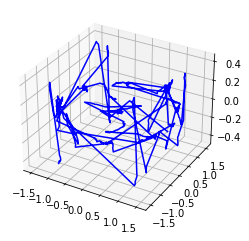

In [23]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = torus_bary[:,0]
Y = torus_bary[:,1]
Z = torus_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

# Persistent homology of sampled barycenters

/tmp/ipykernel_53553/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


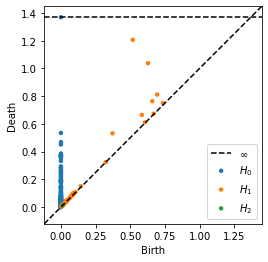

In [24]:
torus_PH_arrays,PH_diagram_barycenters_torus = get_persistence_diagram(torus_bary,2)

# Sphere

In [25]:
expr = x**2 + y**2 + z**2 - 1
poly = sp.Poly(expr, x, y, z)

In [26]:
expr

x**2 + y**2 + z**2 - 1

In [27]:
    # convert sympy polynomial to minyterpy polynomial
newt_poly = sympy_to_mp(poly, mp.NewtonPolynomial)

In [28]:
#sample points
point_data = sample_points_on_poly(1000,        # Number of points to be sampled
                                   newt_poly,  # Polynomial in Newton basis
                                   bounds=1, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [29]:
point_data.shape

(1000, 3)

In [30]:

x_so = point_data[:,0]

y_so = point_data[:,1]

z_so = point_data[:,2]


plot_points = [x_so,y_so,z_so]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [31]:
sphere_bary = get_convergent_barycenters(point_data, 50, point_data[0])

In [32]:
sphere_bary.shape

torch.Size([50, 3])

# Trajectory of barycenter smpling on sphere


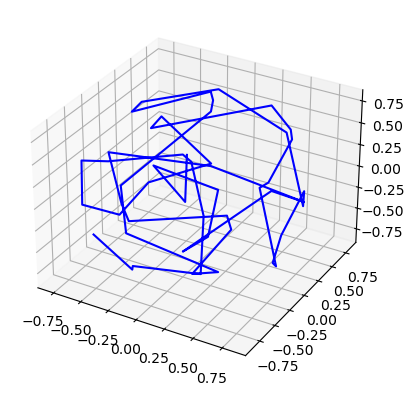

In [33]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = sphere_bary[:,0]
Y = sphere_bary[:,1]
Z = sphere_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

In [34]:
x_sb = sphere_bary[:,0]#.cpu().detach().numpy()

y_sb = sphere_bary[:,1]#.cpu().detach().numpy()

z_sb = sphere_bary[:,2]#.cpu().detach().numpy()



plot_points = [x_sb,y_sb,z_sb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

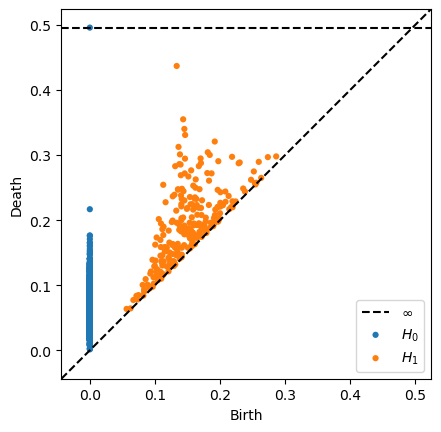

In [35]:
#original point cloud sphere persistence diagram

PH_diagram_spheres = get_persistence_diagram(point_data,1)

/tmp/ipykernel_53553/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


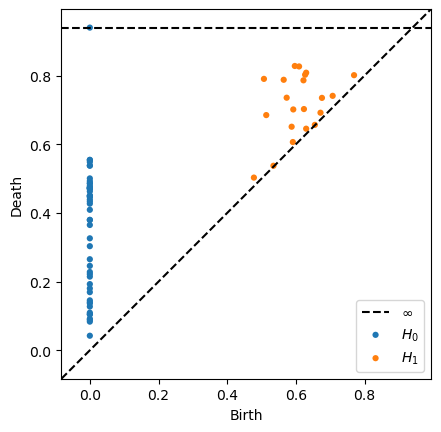

In [36]:
# barycentyers of sphere persistence diagram


PH_diagram_barycenters_sphere = get_persistence_diagram(sphere_bary, 1)